# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

from featureengineering import Documentation, FeatureEngineer, PreProcessor
from common_functions import is_numeric, load_dataframe, save_dataframe, load_model, save_model
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)
sns.set_theme()

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.


## Own Remarks on the Data-Exploration part
* This analysis was the essential part to create the utility classes in [./featureengineering.py](./featureengineering.py).
* The document grew over time so the order of examinations is rather historical... 

In [2]:
# load in the data
root_path='..'
#root_path='C:/projects/_personal/udacity/bertelsmann'

azdias = pd.read_csv(f'{root_path}/data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv(f'{root_path}/data/Udacity_CUSTOMERS_052018.csv', sep=';')
mailout_test = pd.read_csv(f'{root_path}/data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
mailout_train = pd.read_csv(f'{root_path}/data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

C:\Users\thorssc\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
customers.columns[18:20]

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')

In [4]:
azdias.columns[18:20]

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')

In [5]:
mailout_train.columns[18:20]

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')

In [6]:
mailout_test.columns[18:20]

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')

&rArr; the Object-type seems to be the reason for the warning (later more)

## Analyze LNR

In [7]:
print(customers['LNR'].shape[0]-len(customers['LNR'].unique()))
print(azdias['LNR'].shape[0]-len(azdias['LNR'].unique()))
print(mailout_train['LNR'].shape[0]-len(mailout_train['LNR'].unique()))
print(mailout_test['LNR'].shape[0]-len(mailout_test['LNR'].unique()))


0
0
0
0


&rArr; LNR is unique

### Use LNR as index

In [3]:
customers = customers.set_index('LNR')
azdias = azdias.set_index('LNR')
mailout_train = mailout_train.set_index('LNR')
mailout_test = mailout_test.set_index('LNR')

## Transform the DIAS META EXCEL (DIAS Attributes - Values 2017.xlsx) to Dictionary

In [4]:
# Analyze
def is_numeric(val):
    try:
        float(val)
        return True
    except Exception:
        return False


# function to generate dictionary
def transform_attributes_to_dict(df: pd.DataFrame):
    key = None
    last_valid_val = None
    meta_dict = {}
    for idx,row in df.iterrows():
        if not pd.isna(row[1]):
            key = row[1]
            meta_dict[key] ={
                'desc': row[2],
                'items': {},
            }
        if not pd.isna(row[4]):
            last_valid_val = str(row[4]).strip()
        if key:
            if isinstance(row[3], str):
                vals = list(map(lambda it: str(it).strip(), row[3].split(',')))
                for val in vals:
                    meta_dict[key]['items'][val] = str(row[4]).strip()
            else:
                meta_dict[key]['items'][str(row[3]).strip()] = last_valid_val
    return meta_dict

In [5]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
documentation=pd.read_excel(f'{root_path}/data/DIAS Attributes - Values 2017.xlsx', header=None)\
                .dropna(axis=0, how='all')\
                .dropna(axis=1, how='all')
meta_dict = transform_attributes_to_dict(documentation.iloc[1:,:])

### Dictionary Structure

* Some columns as samples entries

In [11]:
sample_dict = {}
sample_dict['ALTERSKATEGORIE_GROB'] = meta_dict['ALTERSKATEGORIE_GROB']
sample_dict['ANZ_TITEL'] = meta_dict['ANZ_TITEL']
sample_dict['BALLRAUM'] = meta_dict['BALLRAUM']
sample_dict['LP_FAMILIE_GROB'] = meta_dict['LP_FAMILIE_GROB']
sample_dict['RELAT_AB'] = meta_dict['RELAT_AB']

sample_dict

{'ALTERSKATEGORIE_GROB': {'desc': 'age classification through prename analysis ',
  'items': {'-1': 'unknown',
   '0': 'unknown',
   '1': '< 30 years',
   '2': '30 - 45 years',
   '3': '46 - 60 years',
   '4': '> 60 years',
   '9': 'uniformly distributed'}},
 'ANZ_TITEL': {'desc': 'number of professional title holder in household ',
  'items': {'…': 'numeric value (typically coded from 1-10)'}},
 'BALLRAUM': {'desc': 'distance to next urban centre ',
  'items': {'-1': 'unknown',
   '1': 'till 10 km',
   '2': '10 - 20 km',
   '3': '20 - 30 km',
   '4': '30 - 40 km',
   '5': '40 - 50 km',
   '6': '50-100 km',
   '7': 'more than 100 km'}},
 'LP_FAMILIE_GROB': {'desc': 'familytyp rough',
  'items': {'1': 'single',
   '2': 'couple',
   '3': 'single parent',
   '4': 'single parent',
   '5': 'single parent',
   '6': 'family',
   '7': 'family',
   '8': 'family',
   '9': 'multiperson household',
   '10': 'multiperson household',
   '11': 'multiperson household'}},
 'RELAT_AB': {'desc': 'share o

In [12]:
# Delete sampledict
del sample_dict

## Check attribute containment among the dataframes and between te dataframes and the DIAS-documentation

### Overview of column counts

In [13]:
print('Number of columns azdias:', len(set(azdias.columns)))
print('Number of columns customers:', len(set(customers.columns)))
print('Number of columns mailout_train:', len(set(mailout_train.columns)))
print('Number of columns mailout_test:', len(set(mailout_test.columns)))
print('Number of columns in META EXCEL:', len(set(meta_dict.keys())))

Number of columns azdias: 365
Number of columns customers: 368
Number of columns mailout_train: 366
Number of columns mailout_test: 365
Number of columns in META EXCEL: 314


### Check columns azdias vs. customers

In [14]:
customer_special_columns = set(customers.columns)-set(azdias.columns)
customer_special_columns

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

&rArr; All other column names are the same in cutomers and azdias. So the three additional columns in customer can be removed.

### Remove unneeded columns in customers

In [15]:
customers = customers.drop(columns=customer_special_columns, axis=1, errors='ignore')

### Check columns mailout_train vs. mailout_test

In [16]:
set(mailout_train.columns)-set(mailout_test.columns)

{'RESPONSE'}

&rArr; Apart from the **RESPONSE** column the columns in mailout_train and mailout_test are identical

### Check columns mailout_test vs. azdias

In [17]:
set(mailout_test.columns)-set(azdias.columns)

set()

&rArr; All other column names are the same in all the Dataframes

### Check DIAS documentation vs. customers

In [18]:
meta_not_customers = sorted(set(meta_dict.keys())-set(customers.columns))
print(len(meta_not_customers))
meta_not_customers

42


['BIP_FLAG',
 'CAMEO_DEUINTL_2015',
 'D19_BANKEN_DIREKT_RZ',
 'D19_BANKEN_GROSS_RZ',
 'D19_BANKEN_LOKAL_RZ',
 'D19_BANKEN_REST_RZ',
 'D19_BEKLEIDUNG_GEH_RZ',
 'D19_BEKLEIDUNG_REST_RZ',
 'D19_BILDUNG_RZ',
 'D19_BIO_OEKO_RZ',
 'D19_BUCH_RZ',
 'D19_DIGIT_SERV_RZ',
 'D19_DROGERIEARTIKEL_RZ',
 'D19_ENERGIE_RZ',
 'D19_FREIZEIT_RZ',
 'D19_GARTEN_RZ',
 'D19_HANDWERK_RZ',
 'D19_HAUS_DEKO_RZ',
 'D19_KINDERARTIKEL_RZ',
 'D19_KK_KUNDENTYP',
 'D19_KOSMETIK_RZ',
 'D19_LEBENSMITTEL_RZ',
 'D19_LOTTO_RZ',
 'D19_NAHRUNGSERGAENZUNG_RZ',
 'D19_RATGEBER_RZ',
 'D19_REISEN_RZ',
 'D19_SAMMELARTIKEL_RZ',
 'D19_SCHUHE_RZ',
 'D19_SONSTIGE_RZ',
 'D19_TECHNIK_RZ',
 'D19_TELKO_MOBILE_RZ',
 'D19_TELKO_REST_RZ',
 'D19_TIERARTIKEL_RZ',
 'D19_VERSAND_REST_RZ',
 'D19_VERSICHERUNGEN_RZ',
 'D19_VOLLSORTIMENT_RZ',
 'D19_WEIN_FEINKOST_RZ',
 'GEOSCORE_KLS7',
 'HAUSHALTSSTRUKTUR',
 'KBA13_CCM_1400_2500',
 'SOHO_FLAG',
 'WACHSTUMSGEBIET_NB']

&rArr; **42** Attributes in the DIAS Meta-Values are not contained in customers (and as a consequence not in the others...)

that means customers and documentation have only 314-42 = 272 common Atributes

Suspects:
* The List shows a lot of values ending with *'_RZ'* whereas the columns in customers exists without the *'_RZ'*.
So we try to Remove the *_RZ* from the documentation. (consistency will be checked later)

### Remove *_RZ-suffix* from the Attribute name in the DIAS documentation 

In [19]:
keys_to_rename = list(filter(lambda it: '_RZ' in str(it), meta_dict.keys()))
for key_to_rename in keys_to_rename:
    meta_dict[str(key_to_rename).replace('_RZ', '')] = meta_dict.pop(key_to_rename)

del key_to_rename, keys_to_rename
print(len(set(meta_dict.keys())-set(customers.columns)))
sorted(set(meta_dict.keys())-set(customers.columns))

9


['BIP_FLAG',
 'CAMEO_DEUINTL_2015',
 'D19_BUCH',
 'D19_KK_KUNDENTYP',
 'GEOSCORE_KLS7',
 'HAUSHALTSSTRUKTUR',
 'KBA13_CCM_1400_2500',
 'SOHO_FLAG',
 'WACHSTUMSGEBIET_NB']

&rArr; we have 9 unmapped columns left now

Manual Review shoed we can explicitly rename some
* 'CAMEO_DEUINTL_2015' -> 'CAMEO_INTL_2015',
* 'D19_BUCH' -> 'D19_BUCH_CD',
* 'KBA13_CCM_1400_2500' -> KBA13_CCM_1401_2500,
* 'SOHO_FLAG' -> SOHO_KZ,

In [20]:
meta_dict['CAMEO_INTL_2015'] = meta_dict.pop('CAMEO_DEUINTL_2015')
meta_dict['D19_BUCH_CD'] = meta_dict.pop('D19_BUCH')
meta_dict['KBA13_CCM_1401_2500'] = meta_dict.pop('KBA13_CCM_1400_2500')
meta_dict['SOHO_KZ'] = meta_dict.pop('SOHO_FLAG')

sorted(set(meta_dict.keys())-set(customers.columns))

['BIP_FLAG',
 'D19_KK_KUNDENTYP',
 'GEOSCORE_KLS7',
 'HAUSHALTSSTRUKTUR',
 'WACHSTUMSGEBIET_NB']

&rArr; we only have 5 unmapped attributes left (and that is ok right now)
So **documentation and customer have 309 common Attributes**.

### Check attributes not in DIAS documentation

In [21]:
print(len(set(customers.columns)- set(meta_dict.keys())))
undocumented_attributes = sorted(set(customers.columns)- set(meta_dict.keys()))
undocumented_attributes

56


['AKT_DAT_KL',
 'ALTERSKATEGORIE_FEIN',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ANZ_KINDER',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'ARBEIT',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'D19_KONSUMTYP_MAX',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_SOZIALES',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_VERSI_DATUM',
 'D19_VERSI_OFFLINE_DATUM',
 'D19_VERSI_ONLINE_DATUM',
 'D19_VERSI_ONLINE_QUOTE_12',
 'DSL_FLAG',
 'EINGEFUEGT_AM',
 'EINGEZOGENAM_HH_JAHR',
 'EXTSEL992',
 'FIRMENDICHTE',
 'GEMEINDETYP',
 'HH_DELTA_FLAG',
 'KBA13_ANTG1',
 'KBA13_ANTG2',
 'KBA13_ANTG3',
 'KBA13_ANTG4',
 'KBA13_BAUMAX',
 'KBA13_GBZ',
 'KBA13_HHZ',
 'KBA13_KMH_210',
 'KK_KUNDENTYP',
 'KOMBIALTER',
 'KONSUMZELLE',
 'MOBI_RASTER',
 'RT_KEIN_ANREIZ',
 'RT_SCHNAEPPCHEN',
 'RT_UEBERGROESSE',
 'STRUKTURTYP',
 'UMFELD_ALT',
 'UMFELD_JUNG',
 'UNGLEICHENN_FLAG',
 'VERDICHTUNGSRAUM',
 'VHA',
 'VHN',
 'VK_DHT4A',
 'VK_DISTANZ',
 'VK_ZG11']

&rArr; we have **56**  undocumented attributes

### Check key-types of the items in documentation

In [22]:
def find_attributes_with_non_numeric_keys(meta_dict):
    attributes_with_non_numeric_keys = {}
    for key, value in meta_dict.items():
        for it_key, it_value in value['items'].items():
            if not is_numeric(it_key):
                if not key in attributes_with_non_numeric_keys:
                    attributes_with_non_numeric_keys[key] = []
                attributes_with_non_numeric_keys[key].append((it_key,it_value))
    return attributes_with_non_numeric_keys
            
attributes_with_non_numeric_keys = find_attributes_with_non_numeric_keys(meta_dict)
attributes_with_non_numeric_keys

{'ANZ_HAUSHALTE_AKTIV': [('…', 'numeric value (typically coded from 1-10)')],
 'ANZ_HH_TITEL': [('…', 'numeric value (typically coded from 1-10)')],
 'ANZ_PERSONEN': [('…', 'numeric value (typically coded from 1-3)')],
 'ANZ_TITEL': [('…', 'numeric value (typically coded from 1-10)')],
 'CAMEO_DEU_2015': [('1A', 'Work-Life-Balance'),
  ('1B', 'Wealthy Best Ager'),
  ('1C', 'Successful Songwriter'),
  ('1D', 'Old Nobility'),
  ('1E', 'City Nobility'),
  ('2A', 'Cottage Chic'),
  ('2B', 'Noble Jogger'),
  ('2C', 'Established gourmet'),
  ('2D', 'Fine Management'),
  ('3A', 'Career & Family'),
  ('3B', 'Powershopping Families'),
  ('3C', 'Rural Neighborhood'),
  ('3D', 'Secure Retirement'),
  ('4A', 'Family Starter'),
  ('4B', 'Family Life'),
  ('4C', 'String Trimmer'),
  ('4D', 'Empty Nest'),
  ('4E', 'Golden Ager'),
  ('5A', 'Younger Employees'),
  ('5B', 'Suddenly Family'),
  ('5C', 'Family First'),
  ('5D', 'Stock Market Junkies'),
  ('5E', 'Coffee Rider'),
  ('5F', 'Active Retirement

#### Result:
* The Attributes **'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'GEBURTSJAHR', 'KBA13_ANZAHL_PKW', 'MIN_GEBAEUDEJAHR'** are documented to be numerical features.
* The Attributes **'CAMEO_DEU_2015', 'OST_WEST_KZ'** have nominal values.

### Are there non numeric Columns in the provided DataFrames?
* which data types are in the dicts

In [23]:
print(customers.dtypes.unique())
print(azdias.dtypes.unique())
print(mailout_train.dtypes.unique())
print(mailout_test.dtypes.unique())

[dtype('int64') dtype('float64') dtype('O')]
[dtype('int64') dtype('float64') dtype('O')]
[dtype('int64') dtype('float64') dtype('O')]
[dtype('int64') dtype('float64') dtype('O')]


&rArr; We have the basic types **int, float, object** in **customers/azdias/mailout_...**

#### Investigate the Object-type columns 

In [24]:
customers.select_dtypes(include='object').columns

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'],
      dtype='object')

In [25]:
azdias.select_dtypes(include='object').columns

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'],
      dtype='object')

In [26]:
mailout_test.select_dtypes(include='object').columns

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'],
      dtype='object')

In [27]:
mailout_test.select_dtypes(include='object').columns

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'],
      dtype='object')

&rArr; The Columns **'CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE',
'EINGEFUEGT_AM' and 'OST_WEST_KZ'** have dtype **object** in all provided DataFrames

* The column **'EINGEFUEGT_AM'** contains date values.
* As **'EINGEFUEGT_AM'** means *'inserted on'*, it is an insertion timestamp and can be regarded as METADATA.
* The column **'MIN_GEBAEUDEJAHR'** is also Meta information as it means the 'year the building was first mentioned in our Database'

&rArr; The column **'EINGEFUEGT_AM'** can be deleted

&rArr; The column **'MIN_GEBAEUDEJAHR'** can be deleted

In [28]:
customers = customers.drop(columns=['EINGEFUEGT_AM'], axis=1, errors='ignore')
azdias = azdias.drop(columns=['EINGEFUEGT_AM'], axis=1, errors='ignore')
mailout_train = mailout_train.drop(columns=['EINGEFUEGT_AM'], axis=1, errors='ignore')
mailout_test = mailout_test.drop(columns=['EINGEFUEGT_AM'], axis=1, errors='ignore')

customers = customers.drop(columns=['MIN_GEBAEUDEJAHR'], axis=1, errors='ignore')
azdias = azdias.drop(columns=['MIN_GEBAEUDEJAHR'], axis=1, errors='ignore')
mailout_train = mailout_train.drop(columns=['MIN_GEBAEUDEJAHR'], axis=1, errors='ignore')
mailout_test = mailout_test.drop(columns=['MIN_GEBAEUDEJAHR'], axis=1, errors='ignore')

### Explore  the Values of the other Object-columns

In [29]:
def dump_distinct_non_null_values(df):
    for col in df.columns:
        values = sorted([elem for elem in df[col].unique() if not pd.isnull(elem)], key=lambda it: str(it))
        print(f'{col}, ({len(values)}) distinct elements, content:')
        print(values, '\n')

In [30]:
dump_distinct_non_null_values(customers.select_dtypes(include='object'))

CAMEO_DEU_2015, (45) distinct elements, content:
['1A', '1B', '1C', '1D', '1E', '2A', '2B', '2C', '2D', '3A', '3B', '3C', '3D', '4A', '4B', '4C', '4D', '4E', '5A', '5B', '5C', '5D', '5E', '5F', '6A', '6B', '6C', '6D', '6E', '6F', '7A', '7B', '7C', '7D', '7E', '8A', '8B', '8C', '8D', '9A', '9B', '9C', '9D', '9E', 'XX'] 

CAMEO_DEUG_2015, (19) distinct elements, content:
['1', 1.0, '2', 2.0, '3', 3.0, '4', 4.0, '5', 5.0, '6', 6.0, '7', 7.0, '8', 8.0, '9', 9.0, 'X'] 

CAMEO_INTL_2015, (43) distinct elements, content:
['12', 12.0, '13', 13.0, '14', 14.0, '15', 15.0, '22', 22.0, '23', 23.0, '24', 24.0, '25', 25.0, '31', 31.0, '32', 32.0, '33', 33.0, '34', 34.0, '35', 35.0, '41', 41.0, '43', 43.0, '44', 44.0, '45', 45.0, '51', 51.0, '52', 52.0, '54', 54.0, '55', 55.0, 'XX'] 

D19_LETZTER_KAUF_BRANCHE, (35) distinct elements, content:
['D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D1

In [31]:
dump_distinct_non_null_values(azdias.select_dtypes(include='object'))

CAMEO_DEU_2015, (45) distinct elements, content:
['1A', '1B', '1C', '1D', '1E', '2A', '2B', '2C', '2D', '3A', '3B', '3C', '3D', '4A', '4B', '4C', '4D', '4E', '5A', '5B', '5C', '5D', '5E', '5F', '6A', '6B', '6C', '6D', '6E', '6F', '7A', '7B', '7C', '7D', '7E', '8A', '8B', '8C', '8D', '9A', '9B', '9C', '9D', '9E', 'XX'] 

CAMEO_DEUG_2015, (19) distinct elements, content:
['1', 1.0, '2', 2.0, '3', 3.0, '4', 4.0, '5', 5.0, '6', 6.0, '7', 7.0, '8', 8.0, '9', 9.0, 'X'] 

CAMEO_INTL_2015, (43) distinct elements, content:
['12', 12.0, '13', 13.0, '14', 14.0, '15', 15.0, '22', 22.0, '23', 23.0, '24', 24.0, '25', 25.0, '31', 31.0, '32', 32.0, '33', 33.0, '34', 34.0, '35', 35.0, '41', 41.0, '43', 43.0, '44', 44.0, '45', 45.0, '51', 51.0, '52', 52.0, '54', 54.0, '55', 55.0, 'XX'] 

D19_LETZTER_KAUF_BRANCHE, (35) distinct elements, content:
['D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D1

In [32]:
dump_distinct_non_null_values(mailout_train.select_dtypes(include='object'))

CAMEO_DEU_2015, (45) distinct elements, content:
['1A', '1B', '1C', '1D', '1E', '2A', '2B', '2C', '2D', '3A', '3B', '3C', '3D', '4A', '4B', '4C', '4D', '4E', '5A', '5B', '5C', '5D', '5E', '5F', '6A', '6B', '6C', '6D', '6E', '6F', '7A', '7B', '7C', '7D', '7E', '8A', '8B', '8C', '8D', '9A', '9B', '9C', '9D', '9E', 'XX'] 

CAMEO_DEUG_2015, (19) distinct elements, content:
['1', 1.0, '2', 2.0, '3', 3.0, '4', 4.0, '5', 5.0, '6', 6.0, '7', 7.0, '8', 8.0, '9', 9.0, 'X'] 

CAMEO_INTL_2015, (43) distinct elements, content:
['12', 12.0, '13', 13.0, '14', 14.0, '15', 15.0, '22', 22.0, '23', 23.0, '24', 24.0, '25', 25.0, '31', 31.0, '32', 32.0, '33', 33.0, '34', 34.0, '35', 35.0, '41', 41.0, '43', 43.0, '44', 44.0, '45', 45.0, '51', 51.0, '52', 52.0, '54', 54.0, '55', 55.0, 'XX'] 

D19_LETZTER_KAUF_BRANCHE, (35) distinct elements, content:
['D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D1

In [33]:
dump_distinct_non_null_values(mailout_test.select_dtypes(include='object'))

CAMEO_DEU_2015, (45) distinct elements, content:
['1A', '1B', '1C', '1D', '1E', '2A', '2B', '2C', '2D', '3A', '3B', '3C', '3D', '4A', '4B', '4C', '4D', '4E', '5A', '5B', '5C', '5D', '5E', '5F', '6A', '6B', '6C', '6D', '6E', '6F', '7A', '7B', '7C', '7D', '7E', '8A', '8B', '8C', '8D', '9A', '9B', '9C', '9D', '9E', 'XX'] 

CAMEO_DEUG_2015, (19) distinct elements, content:
['1', 1.0, '2', 2.0, '3', 3.0, '4', 4.0, '5', 5.0, '6', 6.0, '7', 7.0, '8', 8.0, '9', 9.0, 'X'] 

CAMEO_INTL_2015, (43) distinct elements, content:
['12', 12.0, '13', 13.0, '14', 14.0, '15', 15.0, '22', 22.0, '23', 23.0, '24', 24.0, '25', 25.0, '31', 31.0, '32', 32.0, '33', 33.0, '34', 34.0, '35', 35.0, '41', 41.0, '43', 43.0, '44', 44.0, '45', 45.0, '51', 51.0, '52', 52.0, '54', 54.0, '55', 55.0, 'XX'] 

D19_LETZTER_KAUF_BRANCHE, (35) distinct elements, content:
['D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D1

After looking up the Results in the EXCEL we can sum the things up.

**Summary**
* The Dataframes azdias, customers have the **same distinct values** in the columns of type object.
* The column **'CAMEO_DEU_2015'** has **nominal** values. The value **'XX'** is not contained in the EXCEL and can be regarded as a missing value.
* The column **'CAMEO_DEUG_2015'** has **ordinal** value **'X'** that can be regarded as equal to np.nan as it not in the EXCEL. Without the value **'X'** the column type is castable to **int** or **float**.
* The column **'CAMEO_INTL_2015'** has a value **'XX'** that can be regarded as equal to np.nan as it not in the EXCEL. Without the value **'X'** the column type is castable to **int** or **float**.
* The column **'OST_WEST_KZ'** can be numerically encoded

### Value Ranges - do the values in the Dataframes conform to the DIAS Documentation EXCEL ?

**Remark**: If the value Ranges conform to the EXCEL then we can conclude that the renaming of the column names in the DIAS documentation was ok.

In [34]:
numeric_attributes_from_meta_dict = [
    'ANZ_HAUSHALTE_AKTIV', 
    'ANZ_HH_TITEL', 
    'ANZ_PERSONEN', 
    'ANZ_TITEL', 
    'GEBURTSJAHR', 
    'KBA13_ANZAHL_PKW',
]

# auxiliary function used in lambda expression
def is_key_of_dict(val, the_dict):
    chk = str(int(val)) if is_numeric(val) else str(val)
    return chk in the_dict

# function to check if the values in the DataFrames are within the ranges defined in the documentation
def analyze_value_ranges(df, meta_dict, numeric_attributes, customer_special_columns):
    check_df = pd.DataFrame()
    meta_dict_keys = set(meta_dict.keys())
    numeric_attributes_set = set(numeric_attributes)
    customer_special_columns_set = set(customer_special_columns)
    for col in df.columns:
        if col in meta_dict_keys and col not in numeric_attributes_set and col not in customer_special_columns_set:
            check_df[col] = df[col]\
                .apply(lambda it: np.nan if pd.isnull(it) or is_key_of_dict(it, meta_dict[col]['items']) else it)
    reduced_check_df = check_df.dropna(axis=0, how='all').dropna(axis=1, how='all')
    
    for col in reduced_check_df.columns:
        content = []
        for attr in reduced_check_df[col]:
            if not pd.isnull(attr):
                content.append(attr)
        print(col, set(content), len(content))

In [35]:
%%time
analyze_value_ranges(customers,
                     meta_dict,
                     numeric_attributes_from_meta_dict,
                     customer_special_columns)

CAMEO_DEU_2015 {'XX'} 126
CAMEO_DEUG_2015 {'X'} 126
CAMEO_INTL_2015 {'XX'} 126
KBA05_MODTEMP {6.0} 765
LP_FAMILIE_FEIN {0.0} 47369
LP_FAMILIE_GROB {0.0} 47369
LP_LEBENSPHASE_FEIN {0.0} 47840
LP_LEBENSPHASE_GROB {0.0} 47728
Wall time: 1min 23s


In [36]:
%%time
analyze_value_ranges(azdias,
                     meta_dict,
                     numeric_attributes_from_meta_dict,
                     customer_special_columns)

CAMEO_DEU_2015 {'XX'} 373
CAMEO_DEUG_2015 {'X'} 373
CAMEO_INTL_2015 {'XX'} 373
KBA05_MODTEMP {6.0} 9549
LP_FAMILIE_FEIN {0.0} 72938
LP_FAMILIE_GROB {0.0} 72938
LP_LEBENSPHASE_FEIN {0.0} 92778
LP_LEBENSPHASE_GROB {0.0} 89718
ORTSGR_KLS9 {0.0} 58
Wall time: 10min 1s


In [37]:
%%time
analyze_value_ranges(mailout_train.drop(columns=['RESPONSE'], axis=1, errors='ignore'),
                     meta_dict,
                     numeric_attributes_from_meta_dict,
                     customer_special_columns)

CAMEO_DEU_2015 {'XX'} 11
CAMEO_DEUG_2015 {'X'} 11
CAMEO_INTL_2015 {'XX'} 11
KBA05_MODTEMP {6.0} 288
LP_FAMILIE_FEIN {0.0} 8208
LP_FAMILIE_GROB {0.0} 8208
LP_LEBENSPHASE_FEIN {0.0} 8298
LP_LEBENSPHASE_GROB {0.0} 8273
ORTSGR_KLS9 {0.0} 4
Wall time: 27 s


In [38]:
%%time
analyze_value_ranges(mailout_test,
                     meta_dict,
                     numeric_attributes_from_meta_dict,
                     customer_special_columns)

CAMEO_DEU_2015 {'XX'} 7
CAMEO_DEUG_2015 {'X'} 7
CAMEO_INTL_2015 {'XX'} 7
KBA05_MODTEMP {6.0} 304
LP_FAMILIE_FEIN {0.0} 8073
LP_FAMILIE_GROB {0.0} 8073
LP_LEBENSPHASE_FEIN {0.0} 8156
LP_LEBENSPHASE_GROB {0.0} 8135
ORTSGR_KLS9 {0.0} 1
Wall time: 29.7 s


* All provided DataFrames show discrepancies with the documentation dict for the same attributes except **'ORTSGR_KLS9'**
which seems to be be OK in the customers df.
* **CAMEO_DEU_2015, CAMEO_DEUG_2015, CAMEO_INTL_2015**: replace ['X','XX'] with NaN.
* **LP_FAMILIE_FEIN, LP_FAMILIE_GROB, LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB, OTSGR_KLS9** have undocumented
**0.0**-values. This could be **'unknow'** values but we cannot be sure. So for LP_FAMILIE_FEIN, LP_FAMILIE_GROB,
LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB, OTSGR_KLS9 the value **0.0** will be replaced with NaN.
* Regarding **'KBA05_MODTEMP'** the will be replaced by the highest value (5)

### Clean the columns

we will apply thze findings from above and clean some columns

In [39]:
%%time
customers['CAMEO_DEU_2015'] = customers['CAMEO_DEU_2015'].apply(lambda it: np.nan if 'XX' == it else it)
customers['CAMEO_DEUG_2015'] = customers['CAMEO_DEUG_2015'].apply(lambda it: np.nan if 'X' == it else it)
customers['CAMEO_INTL_2015'] = customers['CAMEO_INTL_2015'].apply(lambda it: np.nan if 'XX' == it else it)
customers['LP_FAMILIE_GROB'] = customers['LP_FAMILIE_GROB'].apply(lambda it: np.nan if 0.0 == it else it)
customers['LP_FAMILIE_FEIN'] = customers['LP_FAMILIE_FEIN'].apply(lambda it: np.nan if 0.0 == it else it)
customers['LP_LEBENSPHASE_GROB'] = customers['LP_LEBENSPHASE_GROB'].apply(lambda it: np.nan if 0.0 == it else it)
customers['LP_LEBENSPHASE_FEIN'] = customers['LP_LEBENSPHASE_FEIN'].apply(lambda it: np.nan if 0.0 == it else it)
customers['KBA05_MODTEMP'] = customers['KBA05_MODTEMP'].apply(lambda it: 5.0 if 6.0 == it else it)
customers['ORTSGR_KLS9'] = customers['ORTSGR_KLS9'].apply(lambda it: np.nan if 0.0 == it else it)
azdias['CAMEO_DEU_2015'] = azdias['CAMEO_DEU_2015'].apply(lambda it: np.nan if 'XX' == it else it)
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].apply(lambda it: np.nan if 'X' == it else it)
azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].apply(lambda it: np.nan if 'XX' == it else it)
azdias['LP_FAMILIE_GROB'] = azdias['LP_FAMILIE_GROB'].apply(lambda it: np.nan if 0.0 == it else it)
azdias['LP_FAMILIE_FEIN'] = azdias['LP_FAMILIE_FEIN'].apply(lambda it: np.nan if 0.0 == it else it)
azdias['LP_LEBENSPHASE_GROB'] = azdias['LP_LEBENSPHASE_GROB'].apply(lambda it: np.nan if 0.0 == it else it)
azdias['LP_LEBENSPHASE_FEIN'] = azdias['LP_LEBENSPHASE_FEIN'].apply(lambda it: np.nan if 0.0 == it else it)
azdias['KBA05_MODTEMP'] = azdias['KBA05_MODTEMP'].apply(lambda it: 5.0 if 6.0 == it else it)
azdias['ORTSGR_KLS9'] = azdias['ORTSGR_KLS9'].apply(lambda it: np.nan if 0.0 == it else it)
mailout_train['CAMEO_DEU_2015'] = mailout_train['CAMEO_DEU_2015'].apply(lambda it: np.nan if 'XX' == it else it)
mailout_train['CAMEO_DEUG_2015'] = mailout_train['CAMEO_DEUG_2015'].apply(lambda it: np.nan if 'X' == it else it)
mailout_train['CAMEO_INTL_2015'] = mailout_train['CAMEO_INTL_2015'].apply(lambda it: np.nan if 'XX' == it else it)
mailout_train['LP_FAMILIE_GROB'] = mailout_train['LP_FAMILIE_GROB'].apply(lambda it: np.nan if 0.0 == it else it)
mailout_train['LP_FAMILIE_FEIN'] = mailout_train['LP_FAMILIE_FEIN'].apply(lambda it: np.nan if 0.0 == it else it)
mailout_train['LP_LEBENSPHASE_GROB'] = mailout_train['LP_LEBENSPHASE_GROB'].apply(lambda it: np.nan if 0.0 == it else it)
mailout_train['LP_LEBENSPHASE_FEIN'] = mailout_train['LP_LEBENSPHASE_FEIN'].apply(lambda it: np.nan if 0.0 == it else it)
mailout_train['KBA05_MODTEMP'] = mailout_train['KBA05_MODTEMP'].apply(lambda it: 5.0 if 6.0 == it else it)
mailout_train['ORTSGR_KLS9'] = mailout_train['ORTSGR_KLS9'].apply(lambda it: np.nan if 0.0 == it else it)
mailout_test['CAMEO_DEU_2015'] = mailout_test['CAMEO_DEU_2015'].apply(lambda it: np.nan if 'XX' == it else it)
mailout_test['CAMEO_DEUG_2015'] = mailout_test['CAMEO_DEUG_2015'].apply(lambda it: np.nan if 'X' == it else it)
mailout_test['CAMEO_INTL_2015'] = mailout_test['CAMEO_INTL_2015'].apply(lambda it: np.nan if 'XX' == it else it)
mailout_test['LP_FAMILIE_GROB'] = mailout_test['LP_FAMILIE_GROB'].apply(lambda it: np.nan if 0.0 == it else it)
mailout_test['LP_FAMILIE_FEIN'] = mailout_test['LP_FAMILIE_FEIN'].apply(lambda it: np.nan if 0.0 == it else it)
mailout_test['LP_LEBENSPHASE_GROB'] = mailout_test['LP_LEBENSPHASE_GROB'].apply(lambda it: np.nan if 0.0 == it else it)
mailout_test['LP_LEBENSPHASE_FEIN'] = mailout_test['LP_LEBENSPHASE_FEIN'].apply(lambda it: np.nan if 0.0 == it else it)
mailout_test['KBA05_MODTEMP'] = mailout_test['KBA05_MODTEMP'].apply(lambda it: 5.0 if 6.0 == it else it)
mailout_test['ORTSGR_KLS9'] = mailout_test['ORTSGR_KLS9'].apply(lambda it: np.nan if 0.0 == it else it)


Wall time: 3.84 s


## Check some concrete columns

### CAMEO_DEU_2015, CAMEO_INTL_2015, CAMEO_DEUG_2015 

* to examine **CAMEO_DEU_2015** we need to labelencode it. We will store the encoded value in the **CAMEO_DEU_2015_LC** column.
* we will also check if there is a linear relation among the attributes (Pearson correlation coefficient)

#### CAMEO_DEU_2015

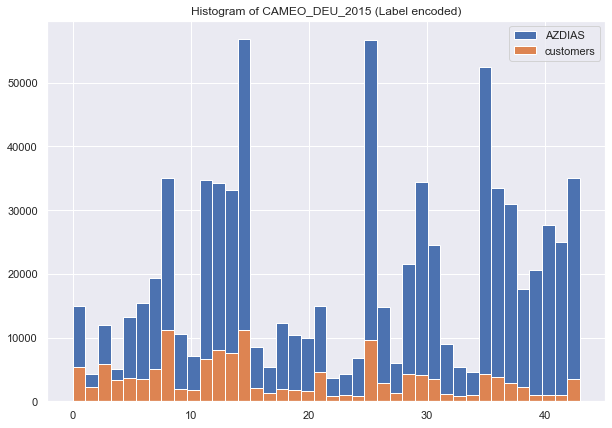

In [40]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

azdias['CAMEO_DEU_2015_X'] = azdias['CAMEO_DEU_2015'].apply(lambda it: 'NaN' if pd.isnull(it) else it)
customers['CAMEO_DEU_2015_X'] = customers['CAMEO_DEU_2015'].apply(lambda it: 'NaN' if pd.isnull(it) else it)

label_encoder = LabelEncoder()
label_encoder.fit(azdias['CAMEO_DEU_2015_X'])
azdias['CAMEO_DEU_2015_LC'] =label_encoder.transform(azdias['CAMEO_DEU_2015_X'])
customers['CAMEO_DEU_2015_LC'] =label_encoder.transform(customers['CAMEO_DEU_2015_X'])

nan_replacement = label_encoder.transform(['NaN'])[0]
azdias['CAMEO_DEU_2015_LC'] = azdias['CAMEO_DEU_2015_LC'].apply(lambda it: np.nan if it == nan_replacement else it)
customers['CAMEO_DEU_2015_LC'] = customers['CAMEO_DEU_2015_LC'].apply(lambda it: np.nan if it == nan_replacement else it)

ax=azdias['CAMEO_DEU_2015_LC'].hist(bins=40, figsize=(10,7))
customers['CAMEO_DEU_2015_LC'].hist(bins=40, figsize=(10,7))
ax.set_title('Histogram of CAMEO_DEU_2015 (Label encoded)')
ax.legend(['AZDIAS', 'customers'])

# %%
# from scipy.stats import chi2_contingency
# data_crosstab = pd.crosstab(azdias['CAMEO_DEU_2015'] ,
#                             customers['CAMEO_DEU_2015'])
# data_crosstab

# %%
#g1, p1, dof, expctd = chi2_contingency(data_crosstab.values)

#print("CONTINGENCY: ",g1, p1, dof, expctd)

#azdias['CAMEO_DEU_2015'].value_counts(sort=True)

#### Lookup the feature in the Documentation


In [41]:
 meta_dict['CAMEO_DEU_2015']

{'desc': 'CAMEO classification 2015 - detailled classification',
 'items': {'1A': 'Work-Life-Balance',
  '1B': 'Wealthy Best Ager',
  '1C': 'Successful Songwriter',
  '1D': 'Old Nobility',
  '1E': 'City Nobility',
  '2A': 'Cottage Chic',
  '2B': 'Noble Jogger',
  '2C': 'Established gourmet',
  '2D': 'Fine Management',
  '3A': 'Career & Family',
  '3B': 'Powershopping Families',
  '3C': 'Rural Neighborhood',
  '3D': 'Secure Retirement',
  '4A': 'Family Starter',
  '4B': 'Family Life',
  '4C': 'String Trimmer',
  '4D': 'Empty Nest',
  '4E': 'Golden Ager',
  '5A': 'Younger Employees',
  '5B': 'Suddenly Family',
  '5C': 'Family First',
  '5D': 'Stock Market Junkies',
  '5E': 'Coffee Rider',
  '5F': 'Active Retirement',
  '6A': 'Jobstarter',
  '6B': 'Petty Bourgeois',
  '6C': 'Long-established',
  '6D': 'Sportgardener',
  '6E': 'Urban Parents',
  '6F': 'Frugal Aging',
  '7A': 'Journeymen',
  '7B': 'Mantaplatte',
  '7C': 'Factory Worker',
  '7D': 'Rear Window',
  '7E': 'Interested Retirees',

In [42]:
len(meta_dict['CAMEO_DEU_2015']['items'])

44

* Nominal (like already said)
* Some attributes look very special regarding semantics
    * Looks like they cover only a small spectrum of possible properties
* high cardinality

#### CAMEO_INTL_2015

99352

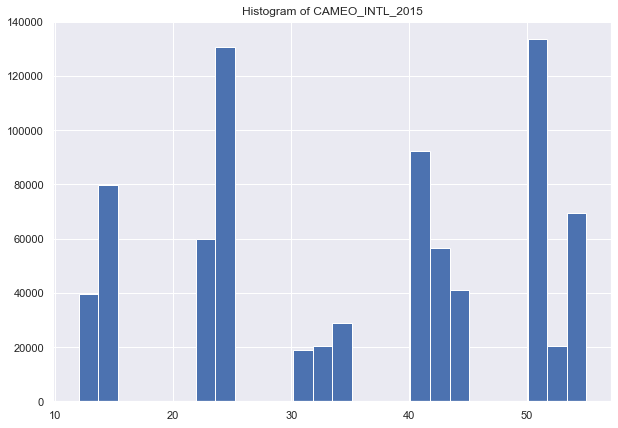

In [43]:
ax=azdias['CAMEO_INTL_2015'].astype('float32').hist(bins=26, figsize=(10,7))
ax.set_title('Histogram of CAMEO_INTL_2015')
azdias['CAMEO_INTL_2015'].isnull().sum()

99352

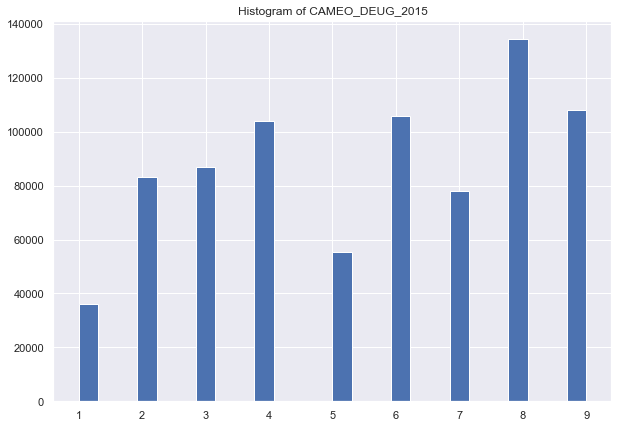

In [44]:
ax = azdias['CAMEO_DEUG_2015'].astype('float32').hist(bins=26, figsize=(10,7))
ax.set_title('Histogram of CAMEO_DEUG_2015')
azdias['CAMEO_DEUG_2015'].isnull().sum()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Correlation CAMEO_DEU_2015, CAMEO_DEUG_2015 0.9937104221123124


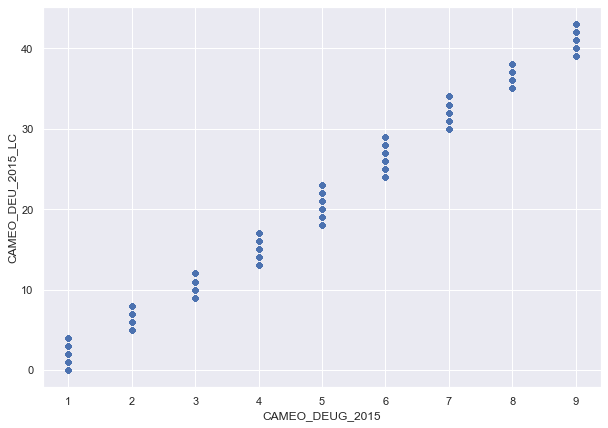

In [45]:
azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015','CAMEO_DEU_2015_LC']]\
    .astype('float32')\
    .plot\
    .scatter(x='CAMEO_DEUG_2015', y='CAMEO_DEU_2015_LC', figsize=(10,7))
print("Correlation CAMEO_DEU_2015, CAMEO_DEUG_2015", azdias['CAMEO_DEU_2015_LC'].corr(azdias['CAMEO_DEUG_2015'].astype('float32')))

&rArr; CAMEO_DEU_2015, CAMEO_DEUG_2015 are highly correlated (correlation=0.9937104221123124)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Correlation CAMEO_INTL_2015, CAMEO_DEUG_2015 0.9555875475962049


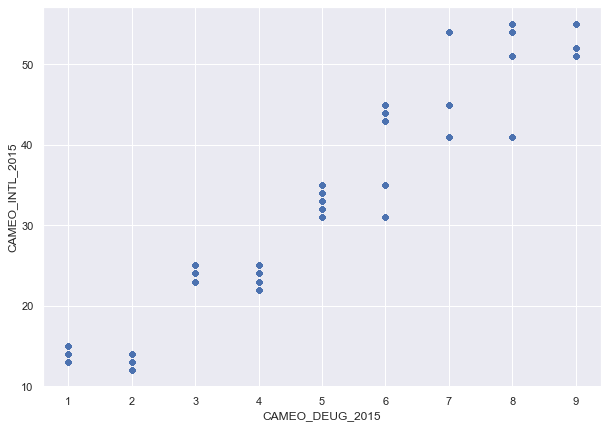

In [46]:
azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015','CAMEO_DEU_2015_LC']]\
    .astype('float32')\
    .plot\
    .scatter(x='CAMEO_DEUG_2015',y='CAMEO_INTL_2015', figsize=(10,7))
print("Correlation CAMEO_INTL_2015, CAMEO_DEUG_2015", azdias['CAMEO_DEUG_2015'].astype('float32').corr(azdias['CAMEO_INTL_2015'].astype('float32')))

&rArr; CAMEO_INTL_2015, CAMEO_DEUG_2015 are also highly correlated (correlation=0.9555875475962049)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Correlation CAMEO_DEU_2015, CAMEO_INTL_2015 0.961882020658234


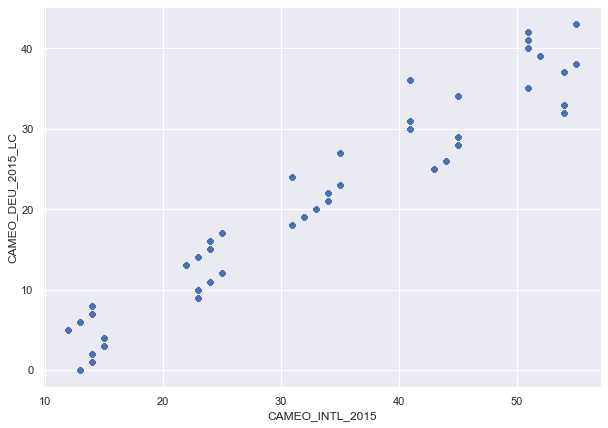

In [47]:
azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015','CAMEO_DEU_2015_LC']]\
    .astype('float32')\
    .plot\
    .scatter(x='CAMEO_INTL_2015',y='CAMEO_DEU_2015_LC', figsize=(10,7))
print("Correlation CAMEO_DEU_2015, CAMEO_INTL_2015", azdias['CAMEO_DEU_2015_LC'].corr(azdias['CAMEO_INTL_2015'].astype('float32')))

&rArr; CAMEO_DEU_2015, CAMEO_INTL_2015 are also highly correlated (correlation=0.961882020658234)

<AxesSubplot:>

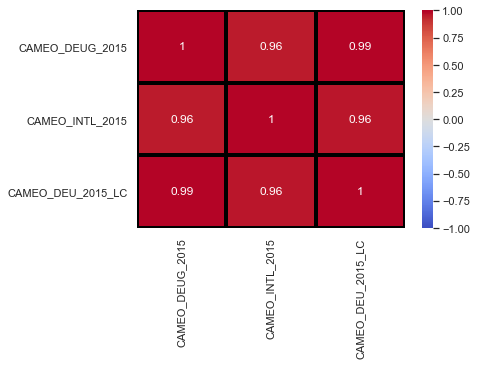

In [48]:
sns.heatmap(azdias[[
    'CAMEO_DEUG_2015',
    'CAMEO_INTL_2015',
    'CAMEO_DEU_2015_LC'
]].astype('float32').corr(),
            annot = True,
            vmin=-1,
            vmax=1,
            center= 0,
            cmap= 'coolwarm',
            linewidths=3,
            linecolor='black')

&rArr; CAMEO_DEU_2015 **can be removed** as it is higly correlated to 'CAMEO_DEUG_2015' otherwise **one hot encoding** would be necessary.

#### Remove the auxiliary columns from the dataframe 

In [49]:
azdias = azdias.drop(columns=['CAMEO_DEU_2015_LC','CAMEO_DEU_2015_X'], axis=1)

### D19_LETZTER_KAUF_BRANCHE

In [50]:
azdias['D19_LETZTER_KAUF_BRANCHE'].value_counts(sort=True)

D19_UNBEKANNT             195338
D19_VERSICHERUNGEN         57734
D19_SONSTIGE               44722
D19_VOLLSORTIMENT          34812
D19_SCHUHE                 32578
D19_BUCH_CD                28754
D19_VERSAND_REST           26034
D19_DROGERIEARTIKEL        24072
D19_BANKEN_DIREKT          23273
D19_BEKLEIDUNG_REST        21796
D19_HAUS_DEKO              20858
D19_TELKO_MOBILE           14447
D19_ENERGIE                12084
D19_TELKO_REST             11472
D19_BANKEN_GROSS           10550
D19_BEKLEIDUNG_GEH         10272
D19_KINDERARTIKEL           7301
D19_FREIZEIT                7257
D19_TECHNIK                 7002
D19_LEBENSMITTEL            6458
D19_BANKEN_REST             5247
D19_RATGEBER                4931
D19_NAHRUNGSERGAENZUNG      4061
D19_DIGIT_SERV              3577
D19_REISEN                  3122
D19_TIERARTIKEL             2578
D19_SAMMELARTIKEL           2443
D19_HANDWERK                2227
D19_WEIN_FEINKOST           2164
D19_GARTEN                  1646
D19_BANKEN

&rArr; D19_UNBEKANNT (meaning 'D19_UNKNOWN') needs to be treated as unknown value so replaced by nan.

### PRAEGENDE_JUGENDJAHRE

* Lookup the documentation of the feature:

In [51]:
meta_dict['PRAEGENDE_JUGENDJAHRE']

{'desc': "dominating movement in the person's youth (avantgarde or mainstream)",
 'items': {'-1': 'unknown',
  '0': 'unknown',
  '1': '40ies - war years (Mainstream, O+W)',
  '2': '40ies - reconstruction years (Avantgarde, O+W)',
  '3': '50ies - economic miracle (Mainstream, O+W)',
  '4': '50ies - milk bar / Individualisation (Avantgarde, O+W)',
  '5': '60ies - economic miracle (Mainstream, O+W)',
  '6': '60ies - generation 68 / student protestors (Avantgarde, W)',
  '7': '60ies - opponents to the building of the Wall (Avantgarde, O)',
  '8': '70ies - family orientation (Mainstream, O+W)',
  '9': '70ies - peace movement (Avantgarde, O+W)',
  '10': '80ies - Generation Golf (Mainstream, W)',
  '11': '80ies - ecological awareness (Avantgarde, W)',
  '12': '80ies - FDJ / communist party youth organisation (Mainstream, O)',
  '13': '80ies - Swords into ploughshares (Avantgarde, O)',
  '14': '90ies - digital media kids (Mainstream, O+W)',
  '15': '90ies - ecological awareness (Avantgarde, O+

* Check correlation to 'GEBURTSJAHR' (year of birth)

In [52]:
test_df = azdias[['PRAEGENDE_JUGENDJAHRE','GEBURTSJAHR']]\
    .astype('float32')\
    .replace(0, np.nan)\
    .replace(0.0, np.nan)\
    .replace(-1, np.nan)\
    .replace(-1.0, np.nan)

test_df['PRAEGENDE_JUGENDJAHRE']\
    .corr(test_df['GEBURTSJAHR'])

0.9427983958025491

&rArr; The correlation to GEBURTSJAHR is high (correlation=0.9427983958025491)

Number of elements:  785396
Number of elements with 'GEBURTSJAHR' greater or equal 1975:  181701
Number of elements with 'GEBURTSJAHR' lower 1935:  17004


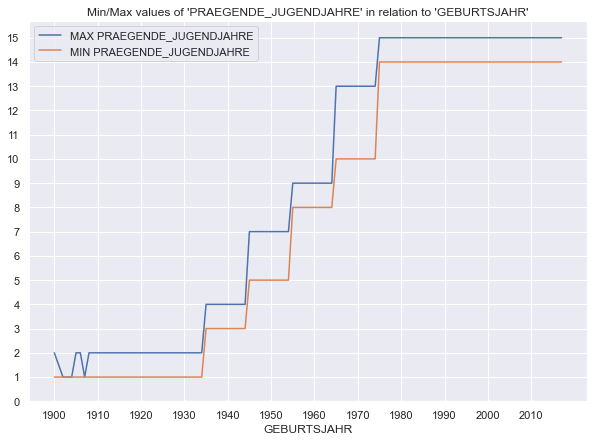

In [53]:
sns.set_theme()
#plt.figure()
test_df = test_df\
    .dropna(axis=0, how='all')\
    .dropna(axis=1, how='all')
ax1=test_df.groupby('GEBURTSJAHR').max().plot(figsize=(10,7))
test_df.groupby('GEBURTSJAHR').min().plot(figsize=(10,7), ax=ax1)

ax1.set_title("Min/Max values of 'PRAEGENDE_JUGENDJAHRE' in relation to 'GEBURTSJAHR'")
ax1.set_xticks(np.arange(1900, 2020, 10))
ax1.set_yticks(np.arange(0,16,1))
ax1.legend(["MAX PRAEGENDE_JUGENDJAHRE", "MIN PRAEGENDE_JUGENDJAHRE"])

print("Number of elements: ", test_df.shape[0])
print("Number of elements with 'GEBURTSJAHR' greater or equal 1975: ",
      test_df[test_df['GEBURTSJAHR']>=1975.0]['GEBURTSJAHR'].count())
print("Number of elements with 'GEBURTSJAHR' lower 1935: ",
      test_df[test_df['GEBURTSJAHR']<1935.0]['GEBURTSJAHR'].count())
    #.replace(14.1,1)\
    #.replace(15.0,1)\


GEBURTSJAHR >= 1975:
* The feature PRAEGENDE_JUGENDJAHRE has a count 181701 values
The feature PRAEGENDE_JUGENDJAHRE has only the values 14,15
that means all people born 1975 or later have their formative years in the 1990s.
GEBURTSJAHR < 1935
* Analogously the conclusion that people born between 1900 and 1935 have their formative years in the 1940s

&rArr; All in all the value range of this feature is too narrow. **Delete the attribute!**

### EINGEZOGENAM_HH_JAHR

Meaning:

* EINGEZOGENAM: 'moved in at'
* HH: ?
* JAHR: Year

In [54]:
print(len(azdias['EINGEZOGENAM_HH_JAHR'].unique()))

38


count    817722.000000
mean       2003.729061
std           7.058204
min        1900.000000
25%        1997.000000
50%        2003.000000
75%        2010.000000
max        2018.000000
Name: EINGEZOGENAM_HH_JAHR, dtype: float64

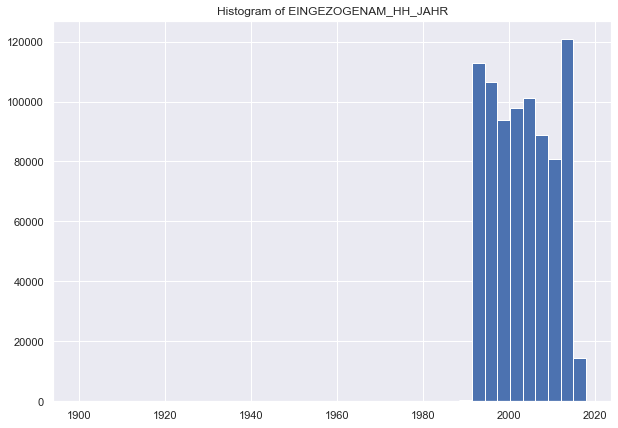

In [55]:
ax=azdias['EINGEZOGENAM_HH_JAHR'].hist(bins=40, figsize=(10,7))
ax.set_title('Histogram of EINGEZOGENAM_HH_JAHR')
azdias['EINGEZOGENAM_HH_JAHR'].describe()

* the values are not plausible; expect more values < 1997

&rArr; Delete **EINGEZOGENAM_HH_JAHR**

### LP_LEBENSPHASE_FEIN

In [56]:
azdias['LP_LEBENSPHASE_FEIN'].corr(azdias['LP_LEBENSPHASE_GROB'])

0.9901527642209288

In [57]:
print(len(azdias['LP_LEBENSPHASE_FEIN'].unique()))

41


count    793589.000000
mean         16.332161
std          12.242378
min           1.000000
25%           6.000000
50%          13.000000
75%          28.000000
max          40.000000
Name: LP_LEBENSPHASE_FEIN, dtype: float64

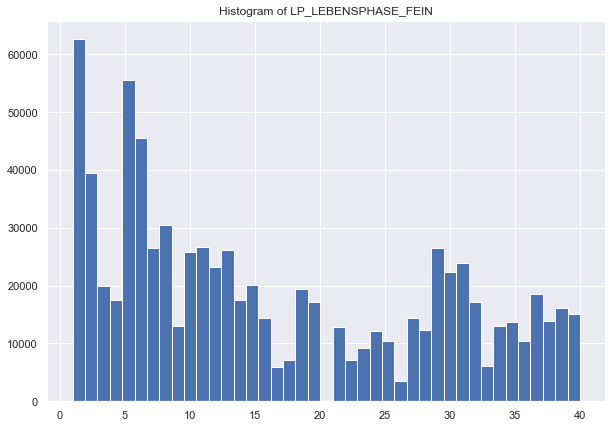

In [58]:
ax=azdias['LP_LEBENSPHASE_FEIN'].hist(bins=41, figsize=(10,7))
ax.set_title('Histogram of LP_LEBENSPHASE_FEIN')
azdias['LP_LEBENSPHASE_FEIN'].describe()

* Reconstructable (with IterativeImputer) from LP_LEBENSPHASE_GROB (correlation=0.9901527642209288)
* Many (41) distinct values
* Would need one hot encoding when used

&rArr; Attribute can be removed

### LP_FAMILIE_FEIN

In [59]:
azdias['LP_FAMILIE_FEIN'].corr(azdias['LP_FAMILIE_GROB'])

0.9882111869839402

In [60]:
print(len(azdias['LP_FAMILIE_FEIN'].unique()))

12


count    813429.000000
mean          3.922339
std           3.941285
min           1.000000
25%           1.000000
50%           1.000000
75%           8.000000
max          11.000000
Name: LP_FAMILIE_FEIN, dtype: float64

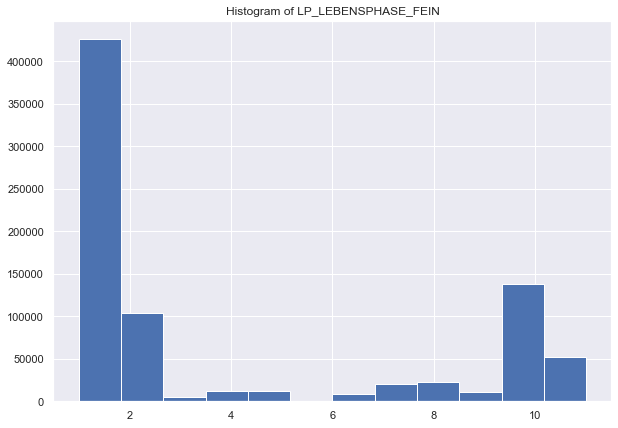

In [61]:
ax=azdias['LP_FAMILIE_FEIN'].hist(bins=12, figsize=(10,7))
ax.set_title('Histogram of LP_LEBENSPHASE_FEIN')
azdias['LP_FAMILIE_FEIN'].describe()

* Reconstructable from LP_FAMILIE_GROB (correlation=0.9882111869839402)

&rArr; Attribute can be removed

### LP_FAMILIE_GROB
Let's check if LP_FAMILIE_GROB is ok

In [6]:
meta_dict['LP_FAMILIE_GROB']

{'desc': 'familytyp rough',
 'items': {'1': 'single',
  '2': 'couple',
  '3': 'single parent',
  '4': 'single parent',
  '5': 'single parent',
  '6': 'family',
  '7': 'family',
  '8': 'family',
  '9': 'multiperson household',
  '10': 'multiperson household',
  '11': 'multiperson household'}}

In [14]:
meta_dict['LP_FAMILIE_FEIN']

{'desc': 'familytyp fine',
 'items': {'1': 'single',
  '2': 'couple',
  '3': 'young single parent',
  '4': 'single parent with teenager',
  '5': 'single parent with child of full age',
  '6': 'young family',
  '7': 'family with teenager',
  '8': 'family with child of full age',
  '9': 'shared flat',
  '10': 'two-generational household',
  '11': 'multi-generational household'}}

In [7]:
azdias['LP_FAMILIE_GROB'].value_counts().sort_index()

0.0     72938
1.0    426379
2.0    104305
3.0     29181
4.0     52784
5.0    200780
Name: LP_FAMILIE_GROB, dtype: int64

In [8]:
customers['LP_FAMILIE_GROB'].value_counts().sort_index()

0.0    47369
1.0    40769
2.0    28937
3.0     1602
4.0     8477
5.0    61285
Name: LP_FAMILIE_GROB, dtype: int64

In [9]:
mailout_train['LP_FAMILIE_GROB'].value_counts().sort_index()

0.0     8208
1.0    12228
2.0     7093
3.0      317
4.0     1041
5.0    13470
Name: LP_FAMILIE_GROB, dtype: int64

In [11]:
mailout_test['LP_FAMILIE_GROB'].value_counts().sort_index()

0.0     8073
1.0    12201
2.0     7026
3.0      327
4.0     1047
5.0    13581
Name: LP_FAMILIE_GROB, dtype: int64

Suspicious! The feature **'LP_FAMILIE_GROB'** uses only the values 1 to 5 that means we have only singles, single couples or single parents in our data. At the same time the feature **'LP_FAMILIE_FEIN'** uses the whole value range as described in the documentation. And we have observes the **high correlation of the features**.

&rArr; All in all it looks like the **documentation of 'LP_FAMILIE_GROB'** is wrong.

Let's check a bit more to get sure:

In [43]:
tmp = azdias[['LP_FAMILIE_FEIN','LP_FAMILIE_GROB']].drop_duplicates().sort_values(by=['LP_FAMILIE_FEIN','LP_FAMILIE_GROB'])
tmp['LABEL'] = tmp['LP_FAMILIE_FEIN'].apply(lambda it: meta_dict['LP_FAMILIE_GROB']['items'][str(int(it))] if not pd.isnull(it) and it>0 else np.nan)
tmp

LP_FAMILIE_FEIN  LP_FAMILIE_GROB                  LABEL
LNR                                                            
910226              0.0              0.0                    NaN
910225              1.0              1.0                 single
910215              2.0              2.0                 couple
568852              3.0              3.0          single parent
577032              4.0              3.0          single parent
910220              5.0              3.0          single parent
710258              6.0              4.0                 family
714263              7.0              4.0                 family
577009              8.0              4.0                 family
876066              9.0              5.0  multiperson household
910241             10.0              5.0  multiperson household
796653             11.0              5.0  multiperson household
705135              NaN              NaN                    NaN

In [44]:
del tmp

Now we can be pretty sure that the documentation is wrong regarding feature **'LP_FAMILIE_GROB'**.
The documentation must be updated:
```
    1: 'single',
    2: 'couple',
    3: 'single parent',
    4: 'family',
    5: 'multiperson household',
```

### LP_STATUS_FEIN

In [62]:
azdias['LP_STATUS_FEIN'].corr(azdias['LP_STATUS_GROB'])

0.9824113392732039

In [63]:
print(len(azdias['LP_STATUS_FEIN'].unique()))

11


count    886367.000000
mean          4.791151
std           3.425305
min           1.000000
25%           2.000000
50%           4.000000
75%           9.000000
max          10.000000
Name: LP_STATUS_FEIN, dtype: float64

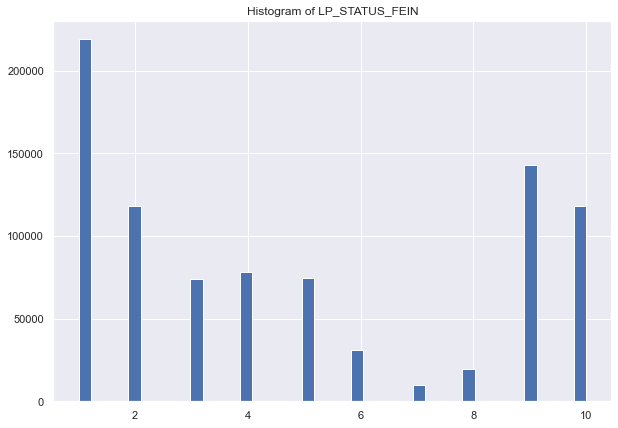

In [64]:
ax=azdias['LP_STATUS_FEIN'].hist(bins=41, figsize=(10,7))
ax.set_title('Histogram of LP_STATUS_FEIN')
azdias['LP_STATUS_FEIN'].describe()

* Reconstructable from LP_STATUS_GROB (correlation=0.9824113392732039)

&rArr; Attribute can be removed

### LP_STATUS_GROB

Check values in documentation

In [33]:
meta_dict['LP_STATUS_GROB']

{'desc': 'social status rough',
 'items': {'1': 'low-income earners',
  '2': 'low-income earners',
  '3': 'average earners',
  '4': 'average earners',
  '5': 'average earners',
  '6': 'independants',
  '7': 'independants',
  '8': 'houseowners',
  '9': 'houseowners',
  '10': 'top earners'}}

In [34]:
meta_dict['LP_STATUS_FEIN']

{'desc': 'social status fine',
 'items': {'1': 'typical low-income earners',
  '2': 'orientationseeking low-income earners',
  '3': 'aspiring low-income earners',
  '4': 'villagers',
  '5': 'minimalistic high-income earners',
  '6': 'independant workers',
  '7': 'title holder-households',
  '8': 'new houseowners',
  '9': 'houseowners',
  '10': 'top earners'}}

Check the used values

In [35]:
azdias['LP_STATUS_GROB'].value_counts().sort_index()

1.0    337511
2.0    226915
3.0     40973
4.0    162946
5.0    118022
Name: LP_STATUS_GROB, dtype: int64

In [36]:
customers['LP_STATUS_GROB'].value_counts().sort_index()

1.0    20675
2.0    62280
3.0    17076
4.0    33755
5.0    54653
Name: LP_STATUS_GROB, dtype: int64

In [37]:
mailout_train['LP_STATUS_GROB'].value_counts().sort_index()

1.0     8656
2.0    12850
3.0     3141
4.0     8579
5.0     9131
Name: LP_STATUS_GROB, dtype: int64

In [38]:
mailout_test['LP_STATUS_GROB'].value_counts().sort_index()

1.0     8821
2.0    12497
3.0     3098
4.0     8712
5.0     9127
Name: LP_STATUS_GROB, dtype: int64

And now **LP_STATUS_FEIN** for **AZDIAS**

In [39]:
azdias['LP_STATUS_FEIN'].value_counts().sort_index()

1.0     219275
2.0     118236
3.0      74105
4.0      78317
5.0      74493
6.0      30914
7.0      10059
8.0      19708
9.0     143238
10.0    118022
Name: LP_STATUS_FEIN, dtype: int64

Suspicious! The feature **'LP_STATUS_GROB'** uses only the values 1 to 5 that means we have only low income or average earners in our data. At the same time the feature **'LP_STATUS_FEIN'** uses the whole value range as described in the documentation. And we have observes the **high correlation of the features**.

&rArr; All in all it looks like the **documentation of 'LP_STATUS_GROB'** is wrong.

Let's check a bit more to get sure:

In [40]:
tmp = azdias[['LP_STATUS_FEIN','LP_STATUS_GROB']].drop_duplicates().sort_values(by=['LP_STATUS_FEIN','LP_STATUS_GROB'])
tmp['LABEL'] = tmp['LP_STATUS_FEIN'].apply(lambda it: meta_dict['LP_STATUS_GROB']['items'][str(int(it))] if not pd.isnull(it) and it>0 else np.nan)
tmp

LP_STATUS_FEIN  LP_STATUS_GROB               LABEL
LNR                                                       
910215             1.0             1.0  low-income earners
910220             2.0             1.0  low-income earners
910225             3.0             2.0     average earners
910244             4.0             2.0     average earners
645169             5.0             2.0     average earners
507892             6.0             3.0        independants
635952             7.0             3.0        independants
612569             8.0             4.0         houseowners
910226             9.0             4.0         houseowners
645145            10.0             5.0         top earners
705135             NaN             NaN                 NaN

In [41]:
del tmp

Now we can be pretty sure that the documentation is wrong regarding feature **'LP_STATUS_GROB'**.
The documentation must be updated:
```
    1: 'low-income earners',
    2: 'average earners',
    3: 'independants',
    4: 'houseowners',
    5: 'top earners',
```

### ALTERSKATEGORIE_FEIN

In [75]:
azdias['ALTERSKATEGORIE_FEIN'].apply(lambda it: np.nan if 0.0 == it else it).corr(azdias['ALTERSKATEGORIE_GROB'])

-0.5890808903550717

In [76]:
azdias['ALTERSKATEGORIE_FEIN'].apply(lambda it: np.nan if 0.0 == it else it).corr(azdias['GEBURTSJAHR'].apply(lambda it: np.nan if 0.0 == it else it))

0.9968670664614107

In [77]:
print(len(azdias['ALTERSKATEGORIE_FEIN'].unique()))

27


count    628274.000000
mean         13.700717
std           5.079849
min           0.000000
25%          11.000000
50%          14.000000
75%          17.000000
max          25.000000
Name: ALTERSKATEGORIE_FEIN, dtype: float64

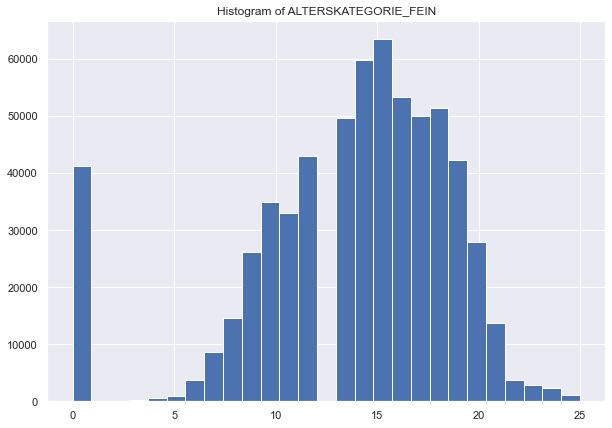

In [78]:
ax=azdias['ALTERSKATEGORIE_FEIN'].hist(bins=27, figsize=(10,7))
ax.set_title('Histogram of ALTERSKATEGORIE_FEIN')
azdias['ALTERSKATEGORIE_FEIN'].describe()

* Looks like 0 is the unknown value
* highly correlated to GEBURTSJAHR (correlation=0.9968670664614107)

&rArr; use it to reconstruct GEBURTSJAHR and delete it afterwards


### ALTERSKATEGORIE_GROB

In [79]:
print(len(azdias['ALTERSKATEGORIE_GROB'].unique()))

5


count    891221.000000
mean          2.777398
std           1.068775
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max           9.000000
Name: ALTERSKATEGORIE_GROB, dtype: float64

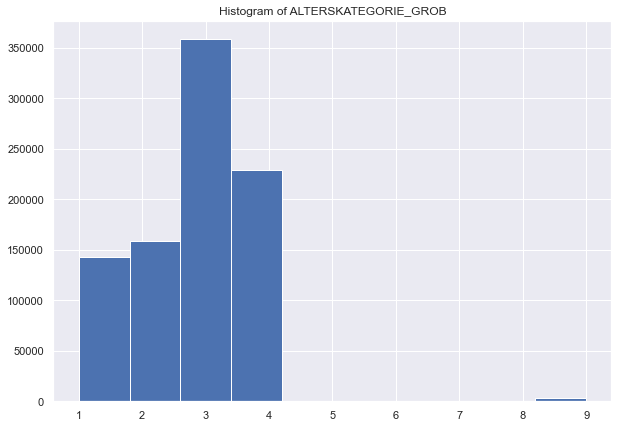

In [80]:
ax = azdias['ALTERSKATEGORIE_GROB'].hist(bins=10, figsize=(10,7))
ax.set_title('Histogram of ALTERSKATEGORIE_GROB')
azdias['ALTERSKATEGORIE_GROB'].describe()

In [81]:
azdias['ALTERSKATEGORIE_GROB'].value_counts()

3    358533
4    228510
2    158410
1    142887
9      2881
Name: ALTERSKATEGORIE_GROB, dtype: int64

* We cannot state that ALTERSKATEGORIE_GROB is the rougher version of ALTERSKATEGORIE_FEIN as we have correlation of -0.5890808903550717

* ALTERSKATEGORIE_GROB: weird meaning 'age through prename analysis'
 
&rArr; remove ALTERSKATEGORIE_GROB

## KBA13_HERST_BMW_BENZ vs. KBA13_BMW, KBA13_MERCEDES

In [82]:
tdf = azdias[['KBA13_HERST_BMW_BENZ','KBA13_BMW','KBA13_MERCEDES']].copy(deep=True)
tdf['BMW_PLUS_BENZ'] = tdf['KBA13_BMW'] + tdf['KBA13_MERCEDES']
tdf.corr()

KBA13_HERST_BMW_BENZ  KBA13_BMW  KBA13_MERCEDES  \
KBA13_HERST_BMW_BENZ              1.000000   0.719702        0.813062   
KBA13_BMW                         0.719702   1.000000        0.389958   
KBA13_MERCEDES                    0.813062   0.389958        1.000000   
BMW_PLUS_BENZ                     0.919916   0.829466        0.837795   

                      BMW_PLUS_BENZ  
KBA13_HERST_BMW_BENZ       0.919916  
KBA13_BMW                  0.829466  
KBA13_MERCEDES             0.837795  
BMW_PLUS_BENZ              1.000000

In [83]:
del tdf

* The sum of KBA13_BMW and KBA13_MERCEDES is highly correlated with KBA13_HERST_BMW_BENZ (0.919916)

&rArr; remove  KBA13_BMW, KBA13_MERCEDES and keep KBA13_HERST_BMW_BENZ

## KBA13_HERST_AUDI_VW vs. KBA13_AUDI, KBA13_VW

In [84]:
tdf = azdias[['KBA13_HERST_AUDI_VW','KBA13_AUDI','KBA13_VW']].copy(deep=True)
tdf['AUDI_PLUS_VW'] = tdf['KBA13_AUDI'] + tdf['KBA13_VW']
tdf.corr()

KBA13_HERST_AUDI_VW  KBA13_AUDI  KBA13_VW  AUDI_PLUS_VW
KBA13_HERST_AUDI_VW             1.000000    0.499360  0.869592      0.881510
KBA13_AUDI                      0.499360    1.000000  0.213853      0.772738
KBA13_VW                        0.869592    0.213853  1.000000      0.785294
AUDI_PLUS_VW                    0.881510    0.772738  0.785294      1.000000

In [85]:
del tdf

* The sum of KBA13_AUDI and KBA13_VW is highly correlated with KBA13_HERST_AUDI_VW (0.881510)

&rArr; remove  KBA13_AUDI, KBA13_VW and keep KBA13_HERST_AUDI_VW

## KBA13_HERST_FORD_OPEL vs. KBA13_OPEL, KBA13_FORD

In [86]:
tdf = azdias[['KBA13_HERST_FORD_OPEL','KBA13_OPEL','KBA13_FORD']].copy(deep=True)
tdf['OPEL_PLUS_FORD'] = tdf['KBA13_OPEL'] + tdf['KBA13_FORD']
tdf.corr()

KBA13_HERST_FORD_OPEL  KBA13_OPEL  KBA13_FORD  \
KBA13_HERST_FORD_OPEL               1.000000    0.726853    0.605210   
KBA13_OPEL                          0.726853    1.000000    0.109728   
KBA13_FORD                          0.605210    0.109728    1.000000   
OPEL_PLUS_FORD                      0.894680    0.749016    0.740739   

                       OPEL_PLUS_FORD  
KBA13_HERST_FORD_OPEL        0.894680  
KBA13_OPEL                   0.749016  
KBA13_FORD                   0.740739  
OPEL_PLUS_FORD               1.000000

In [87]:
del tdf

* The sum of KBA13_OPEL and KBA13_FORD is highly correlated with KBA13_HERST_FORD_OPEL (0.881510)

&rArr; remove  KBA13_OPEL, KBA13_FORD and keep KBA13_HERST_FORD_OPEL

## KBA13_HERST_EUROPA vs. KBA13_FIAT, KBA13_PEUGEOT, KBA13_RENAULT

In [88]:
tdf = azdias[['KBA13_HERST_EUROPA','KBA13_FIAT','KBA13_PEUGEOT','KBA13_RENAULT']].copy(deep=True)
tdf['SUM_EUROPA'] = tdf['KBA13_FIAT'] + tdf['KBA13_PEUGEOT'] + tdf['KBA13_RENAULT']
tdf.corr()

KBA13_HERST_EUROPA  KBA13_FIAT  KBA13_PEUGEOT  \
KBA13_HERST_EUROPA            1.000000    0.374045       0.492221   
KBA13_FIAT                    0.374045    1.000000       0.049098   
KBA13_PEUGEOT                 0.492221    0.049098       1.000000   
KBA13_RENAULT                 0.616439   -0.143826       0.081849   
SUM_EUROPA                    0.861224    0.518319       0.654835   

                    KBA13_RENAULT  SUM_EUROPA  
KBA13_HERST_EUROPA       0.616439    0.861224  
KBA13_FIAT              -0.143826    0.518319  
KBA13_PEUGEOT            0.081849    0.654835  
KBA13_RENAULT            1.000000    0.551370  
SUM_EUROPA               0.551370    1.000000

In [89]:
del tdf

* The sum of KBA13_FIAT and KBA13_PEUGEOT and KBA13_RENAULT is highly correlated with KBA13_HERST_EUROPA (0.861224)

&rArr; remove  KBA13_FIAT, KBA13_PEUGEOT, KBA13_RENAULT and keep KBA13_HERST_EUROPA

## KBA13_HERST_ASIEN vs. KBA13_MAZDA, KBA13_NISSAN, KBA13_TOYOTA

In [90]:
tdf = azdias[['KBA13_HERST_ASIEN','KBA13_MAZDA','KBA13_NISSAN','KBA13_TOYOTA']].copy(deep=True)
tdf['SUM_ASIEN'] = tdf['KBA13_MAZDA'] + tdf['KBA13_NISSAN'] + tdf['KBA13_TOYOTA']
tdf.corr()

KBA13_HERST_ASIEN  KBA13_MAZDA  KBA13_NISSAN  KBA13_TOYOTA  \
KBA13_HERST_ASIEN           1.000000     0.477356      0.519052      0.506837   
KBA13_MAZDA                 0.477356     1.000000      0.210897      0.149860   
KBA13_NISSAN                0.519052     0.210897      1.000000      0.149186   
KBA13_TOYOTA                0.506837     0.149860      0.149186      1.000000   
SUM_ASIEN                   0.749923     0.675303      0.682272      0.647356   

                   SUM_ASIEN  
KBA13_HERST_ASIEN   0.749923  
KBA13_MAZDA         0.675303  
KBA13_NISSAN        0.682272  
KBA13_TOYOTA        0.647356  
SUM_ASIEN           1.000000

In [91]:
del tdf

* Admittedly sum of KBA13_MAZDA and KBA13_NISSAN and KBA13_TOYOTA is not that highly correlated with KBA13_HERST_ASIEN (0.749923) as in the other cases above.

&rArr; remove  KBA13_FIAT, KBA13_NISSAN, KBA13_TOYOTA and keep KBA13_HERST_ASIEN for the sake of consistency

## KBA13_ALTERHALTER_30 vs. KBA13_HALTER_20, KBA13_HALTER_25, KBA13_HALTER_30

In [92]:
tdf = azdias[['KBA13_ALTERHALTER_30','KBA13_HALTER_20','KBA13_HALTER_25','KBA13_HALTER_30']].copy(deep=True)
tdf['SUM'] = tdf['KBA13_HALTER_20'] + tdf['KBA13_HALTER_25'] + tdf['KBA13_HALTER_30']
tdf.corr()

KBA13_ALTERHALTER_30  KBA13_HALTER_20  KBA13_HALTER_25  \
KBA13_ALTERHALTER_30              1.000000         0.335395         0.799178   
KBA13_HALTER_20                   0.335395         1.000000         0.508427   
KBA13_HALTER_25                   0.799178         0.508427         1.000000   
KBA13_HALTER_30                   0.849379         0.042772         0.553472   
SUM                               0.878014         0.662027         0.902905   

                      KBA13_HALTER_30       SUM  
KBA13_ALTERHALTER_30         0.849379  0.878014  
KBA13_HALTER_20              0.042772  0.662027  
KBA13_HALTER_25              0.553472  0.902905  
KBA13_HALTER_30              1.000000  0.716734  
SUM                          0.716734  1.000000

In [93]:
del tdf

* The sum of KBA13_HALTER_20 and KBA13_HALTER_25 and KBA13_HALTER_30 is highly correlated with KBA13_ALTERHALTER_30 (0.878014)

&rArr; remove  KBA13_HALTER_20, KBA13_HALTER_25, KBA13_HALTER_30 and keep KBA13_ALTERHALTER_30

## KBA13_ALTERHALTER_45 vs. KBA13_HALTER_35, KBA13_HALTER_40, KBA13_HALTER_45

In [94]:
tdf = azdias[['KBA13_ALTERHALTER_45','KBA13_HALTER_35','KBA13_HALTER_40','KBA13_HALTER_45']].copy(deep=True)
tdf['SUM'] = tdf['KBA13_HALTER_35'] + tdf['KBA13_HALTER_40'] + tdf['KBA13_HALTER_45']
tdf.corr()

KBA13_ALTERHALTER_45  KBA13_HALTER_35  KBA13_HALTER_40  \
KBA13_ALTERHALTER_45              1.000000         0.694863         0.863115   
KBA13_HALTER_35                   0.694863         1.000000         0.620419   
KBA13_HALTER_40                   0.863115         0.620419         1.000000   
KBA13_HALTER_45                   0.606463         0.092089         0.454193   
SUM                               0.937351         0.745898         0.899211   

                      KBA13_HALTER_45       SUM  
KBA13_ALTERHALTER_45         0.606463  0.937351  
KBA13_HALTER_35              0.092089  0.745898  
KBA13_HALTER_40              0.454193  0.899211  
KBA13_HALTER_45              1.000000  0.664246  
SUM                          0.664246  1.000000

In [95]:
del tdf

* The sum of KBA13_HALTER_35 and KBA13_HALTER_40 and KBA13_HALTER_45 is highly correlated with KBA13_ALTERHALTER_45 (0.937351)

&rArr; remove  KBA13_HALTER_35, KBA13_HALTER_40, KBA13_HALTER_45 and keep KBA13_ALTERHALTER_45

## KBA13_ALTERHALTER_60 vs. KBA13_HALTER_50, KBA13_HALTER_55, KBA13_HALTER_60

In [96]:
tdf = azdias[['KBA13_ALTERHALTER_60','KBA13_HALTER_50','KBA13_HALTER_55','KBA13_HALTER_60']].copy(deep=True)
tdf['SUM'] = tdf['KBA13_HALTER_50'] + tdf['KBA13_HALTER_55'] + tdf['KBA13_HALTER_60']
tdf.corr()

KBA13_ALTERHALTER_60  KBA13_HALTER_50  KBA13_HALTER_55  \
KBA13_ALTERHALTER_60              1.000000         0.771793         0.866494   
KBA13_HALTER_50                   0.771793         1.000000         0.654441   
KBA13_HALTER_55                   0.866494         0.654441         1.000000   
KBA13_HALTER_60                   0.682338         0.336620         0.567490   
SUM                               0.938038         0.802565         0.898067   

                      KBA13_HALTER_60       SUM  
KBA13_ALTERHALTER_60         0.682338  0.938038  
KBA13_HALTER_50              0.336620  0.802565  
KBA13_HALTER_55              0.567490  0.898067  
KBA13_HALTER_60              1.000000  0.772621  
SUM                          0.772621  1.000000

In [97]:
del tdf

* The sum of KBA13_HALTER_50 and KBA13_HALTER_55 and KBA13_HALTER_60 is highly correlated with KBA13_ALTERHALTER_60 (0.938038)

&rArr; remove  KBA13_HALTER_50, KBA13_HALTER_25, KBA13_HALTER_60 and keep KBA13_ALTERHALTER_60

## KBA13_ALTERHALTER_61 vs. KBA13_HALTER_65, KBA13_HALTER_66

In [98]:
tdf = azdias[['KBA13_ALTERHALTER_61','KBA13_HALTER_65','KBA13_HALTER_66']].copy(deep=True)
tdf['SUM'] = tdf['KBA13_HALTER_65'] + tdf['KBA13_HALTER_66']
tdf.corr()

KBA13_ALTERHALTER_61  KBA13_HALTER_65  KBA13_HALTER_66  \
KBA13_ALTERHALTER_61              1.000000         0.660367         0.927874   
KBA13_HALTER_65                   0.660367         1.000000         0.511417   
KBA13_HALTER_66                   0.927874         0.511417         1.000000   
SUM                               0.915670         0.865272         0.873301   

                           SUM  
KBA13_ALTERHALTER_61  0.915670  
KBA13_HALTER_65       0.865272  
KBA13_HALTER_66       0.873301  
SUM                   1.000000

In [99]:
del tdf

* The sum of KBA13_HALTER_65 and KBA13_HALTER_66 is highly correlated with KBA13_ALTERHALTER_61 (0.915670)

&rArr; remove  KBA13_HALTER_65, KBA13_HALTER_66 and keep KBA13_ALTERHALTER_61

## KBA05_CCM... vs KBA05_KW...

In [100]:
kba05_cols=['KBA05_CCM1','KBA05_CCM2','KBA05_CCM3','KBA05_CCM4',
           'KBA05_KW1','KBA05_KW2','KBA05_KW3']
tdf = azdias[kba05_cols].copy(deep=True)
tdf = tdf.applymap(lambda it: 0 if it < 0 or it==9.0 else it)
tdf = tdf.dropna().round(0)
tdf['SUM_CCM'] = tdf['KBA05_CCM1'] + tdf['KBA05_CCM2'] + tdf['KBA05_CCM3'] + tdf['KBA05_CCM4']
tdf['SUM_KW'] = tdf['KBA05_KW1'] + tdf['KBA05_KW2'] + tdf['KBA05_KW3']
tdf[['SUM_CCM','SUM_KW']].corr()

SUM_CCM   SUM_KW
SUM_CCM  1.00000  0.80114
SUM_KW   0.80114  1.00000

<AxesSubplot:title={'center':'Korrelations of Engine Size and Enigne Power Features (KBA05_KW... and KBA05_CCM...) '}>

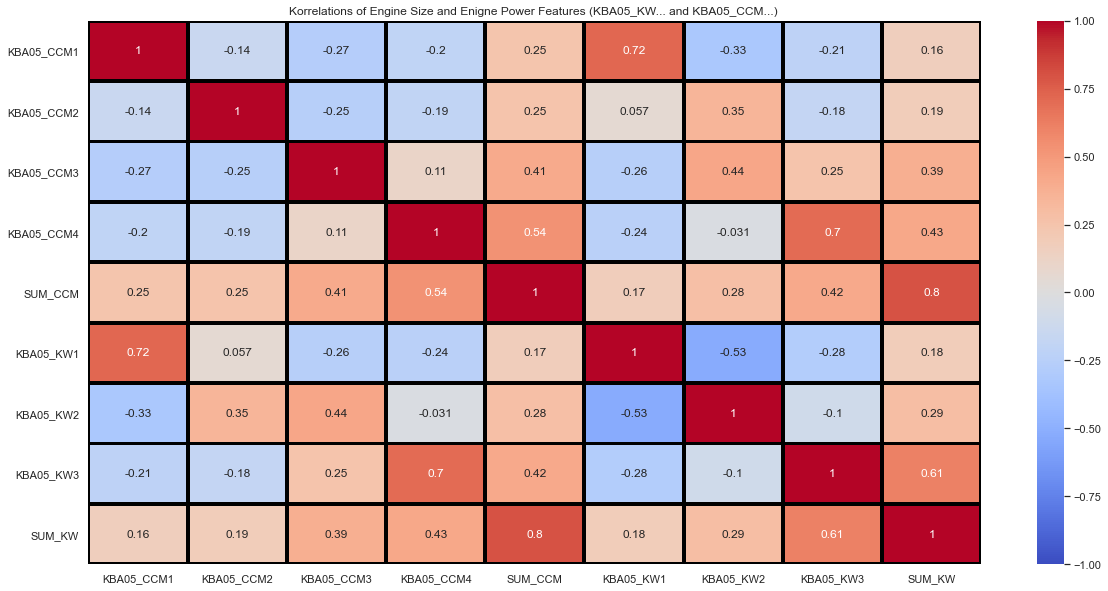

In [101]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
ax.set_title("Korrelations of Engine Size and Enigne Power Features (KBA05_KW... and KBA05_CCM...) ")
sns.heatmap(tdf[[
    'KBA05_CCM1','KBA05_CCM2','KBA05_CCM3','KBA05_CCM4',
    'SUM_CCM',
    'KBA05_KW1','KBA05_KW2','KBA05_KW3',
    'SUM_KW'
]].astype('float32').corr(),
            annot = True,
            vmin=-1,
            vmax=1,
            center= 0,
            cmap= 'coolwarm',
            linewidths=3,
            linecolor='black',
            ax=ax)

In [102]:
del tdf

* The sum of KBA05_CCM... is highly correlated with the sum of KBA05_KW... (0.80114)

&rArr; we could take in regard to remove the KBA05_CCM... attribute but let's keep it for now...

## KBA13_CCM_... vs. KBA13_KW... vs. KBA13_CCM...

In [103]:
kba13_cols=[
    'KBA13_CCM_1000', 'KBA13_CCM_1200', 'KBA13_CCM_1400', 'KBA13_CCM_1500', 
    'KBA13_CCM_1600', 'KBA13_CCM_1800', 'KBA13_CCM_2000', 'KBA13_CCM_2500', 
    'KBA13_CCM_2501', 'KBA13_CCM_3000', 'KBA13_CCM_3001', 
    'KBA13_CCM_0_1400', 'KBA13_CCM_1401_2500', 
    'KBA13_KMH_110', 'KBA13_KMH_140', 'KBA13_KMH_180', 
    'KBA13_KMH_210', 'KBA13_KMH_211', 'KBA13_KMH_250', 'KBA13_KMH_251', 
    'KBA13_KMH_0_140', 'KBA13_KMH_140_210', 
    'KBA13_KW_30', 'KBA13_KW_40', 
    'KBA13_KW_50', 'KBA13_KW_60', 'KBA13_KW_70', 'KBA13_KW_80', 
    'KBA13_KW_90', 'KBA13_KW_110', 'KBA13_KW_120', 'KBA13_KW_121', 
    'KBA13_KW_0_60', 'KBA13_KW_61_120'
]


In [104]:
tdf = azdias[kba13_cols].applymap(lambda it: it + 1.0).copy(deep=True)
tdf = tdf.dropna().round(0)

In [105]:
tdf['SUM_CCM']  = tdf['KBA13_CCM_1000']
tdf['SUM_CCM'] += tdf['KBA13_CCM_1200']
tdf['SUM_CCM'] += tdf['KBA13_CCM_1400']
tdf['SUM_CCM'] += tdf['KBA13_CCM_1500']
tdf['SUM_CCM'] += tdf['KBA13_CCM_1600']
tdf['SUM_CCM'] += tdf['KBA13_CCM_1800']
tdf['SUM_CCM'] += tdf['KBA13_CCM_2000']
tdf['SUM_CCM'] += tdf['KBA13_CCM_2500']
tdf['SUM_CCM'] += tdf['KBA13_CCM_2501']
#tdf['SUM_CCM'] += tdf['KBA13_CCM_3000']
#tdf['SUM_CCM'] += tdf['KBA13_CCM_3001']

#tdf['SUM_CCM'] += tdf['KBA13_CCM_0_1400']
#tdf['SUM_CCM'] += tdf['KBA13_CCM_1401_2500']

tdf['SUM_KMH']  = tdf['KBA13_KMH_110']
tdf['SUM_KMH'] += tdf['KBA13_KMH_140']
tdf['SUM_KMH'] += tdf['KBA13_KMH_180']
tdf['SUM_KMH'] += tdf['KBA13_KMH_210']
tdf['SUM_KMH'] += tdf['KBA13_KMH_211']
#tdf['SUM_KMH'] += tdf['KBA13_KMH_250']
#tdf['SUM_KMH'] += tdf['KBA13_KMH_251']

#tdf['SUM_KMH'] += tdf['KBA13_KMH_0_140']
#tdf['SUM_KMH'] += tdf['KBA13_KMH_140_210']

tdf['SUM_KW']  = tdf['KBA13_KW_30']
tdf['SUM_KW'] += tdf['KBA13_KW_40']
tdf['SUM_KW'] += tdf['KBA13_KW_50']
tdf['SUM_KW'] += tdf['KBA13_KW_60']
tdf['SUM_KW'] += tdf['KBA13_KW_70']
tdf['SUM_KW'] += tdf['KBA13_KW_80']
tdf['SUM_KW'] += tdf['KBA13_KW_90']
tdf['SUM_KW'] += tdf['KBA13_KW_110']
tdf['SUM_KW'] += tdf['KBA13_KW_120']
tdf['SUM_KW'] += tdf['KBA13_KW_121']

#tdf['SUM_KW'] += tdf['KBA13_KW_0_60']
#tdf['SUM_KW'] += tdf['KBA13_KW_61_120']


#tdf[['SUM_CCM','SUM_KW']].hist(bins = 10)
#(tdf[['KBA13_CCM_0_1400','KBA13_CCM_1401_2500','SUM_CCM','KBA13_KW_0_60','KBA13_KW_61_120','SUM_KW']].T != 0).any()
#[col for col in azdias.columns if col.startswith('KBA13_KMH')]

### KBA13_CCM... vs KBA13_KW...

<AxesSubplot:title={'center':'Korrelations of Engine Power Features KBA13_KW... and Engine Size features KBA13_CCM...'}>

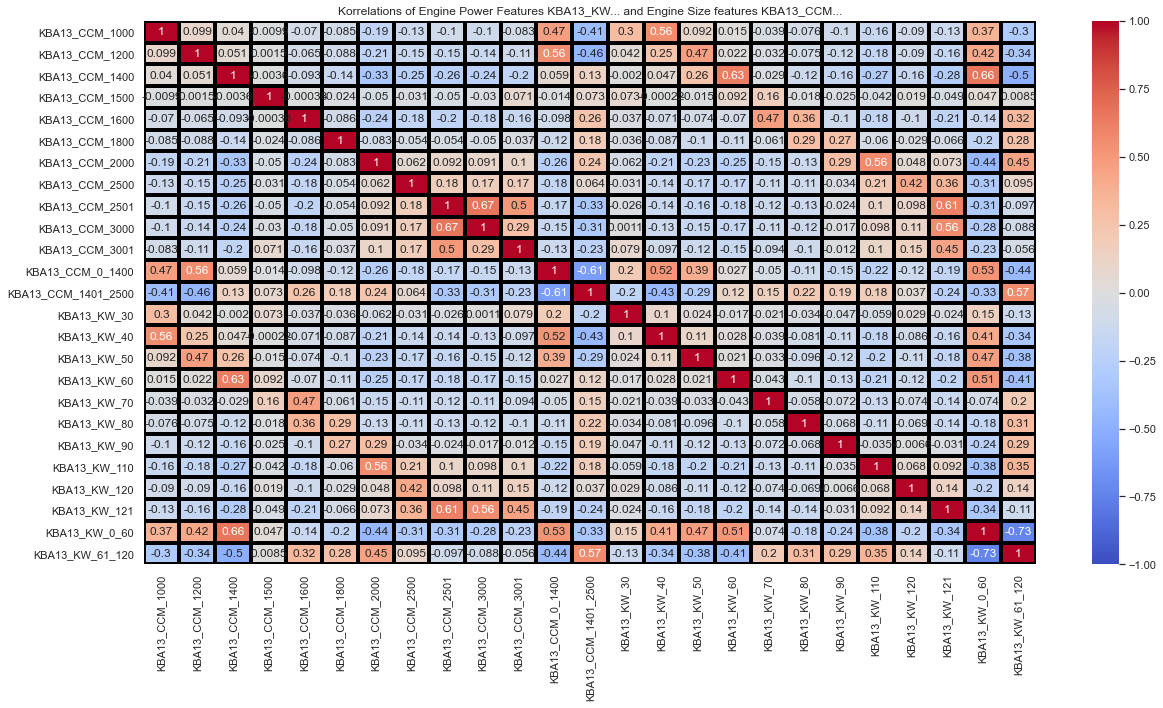

In [106]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
ax.set_title("Korrelations of Engine Power Features KBA13_KW... and Engine Size features KBA13_CCM...")
sns.heatmap(tdf[[
    'KBA13_CCM_1000', 'KBA13_CCM_1200', 'KBA13_CCM_1400', 'KBA13_CCM_1500', 
    'KBA13_CCM_1600', 'KBA13_CCM_1800', 'KBA13_CCM_2000', 'KBA13_CCM_2500', 
    'KBA13_CCM_2501', 'KBA13_CCM_3000', 'KBA13_CCM_3001', 
    'KBA13_CCM_0_1400', 'KBA13_CCM_1401_2500', 
    'KBA13_KW_30', 'KBA13_KW_40', 
    'KBA13_KW_50', 'KBA13_KW_60', 'KBA13_KW_70', 'KBA13_KW_80', 
    'KBA13_KW_90', 'KBA13_KW_110', 'KBA13_KW_120', 'KBA13_KW_121', 
    'KBA13_KW_0_60', 'KBA13_KW_61_120'
]].astype('float32').corr(),
            annot = True,
            vmin=-1,
            vmax=1,
            center= 0,
            cmap= 'coolwarm',
            linewidths=3,
            linecolor='black',
            ax=ax)

* Low correlations 
* 'KBA13_CCM_0_1400' corerelates with 'KBA13_KW_0_60'
* 'KBA13_CCM_1401_2500' correlates with 'KBA13_KW_61_120'
* 'KBA13_CCM_2501' correlates with 'KBA13_KW_121'
* Looks like it would make sense to keep the rough 'KBA13_CCM_0_1400', 'KBA13_CCM_1401_2500', 'KBA13_KW_0_60', 'KBA13_KW_61_120' together with 'KBA13_CCM_2501', 'KBA13_KW_121'
* Throw away all others

### KBA13_KMH... vs KBA13_KW...

<AxesSubplot:title={'center':'Korrelations of Engine Power Features KBA13_KW... and vehicle Speed KBA13_KMH...'}>

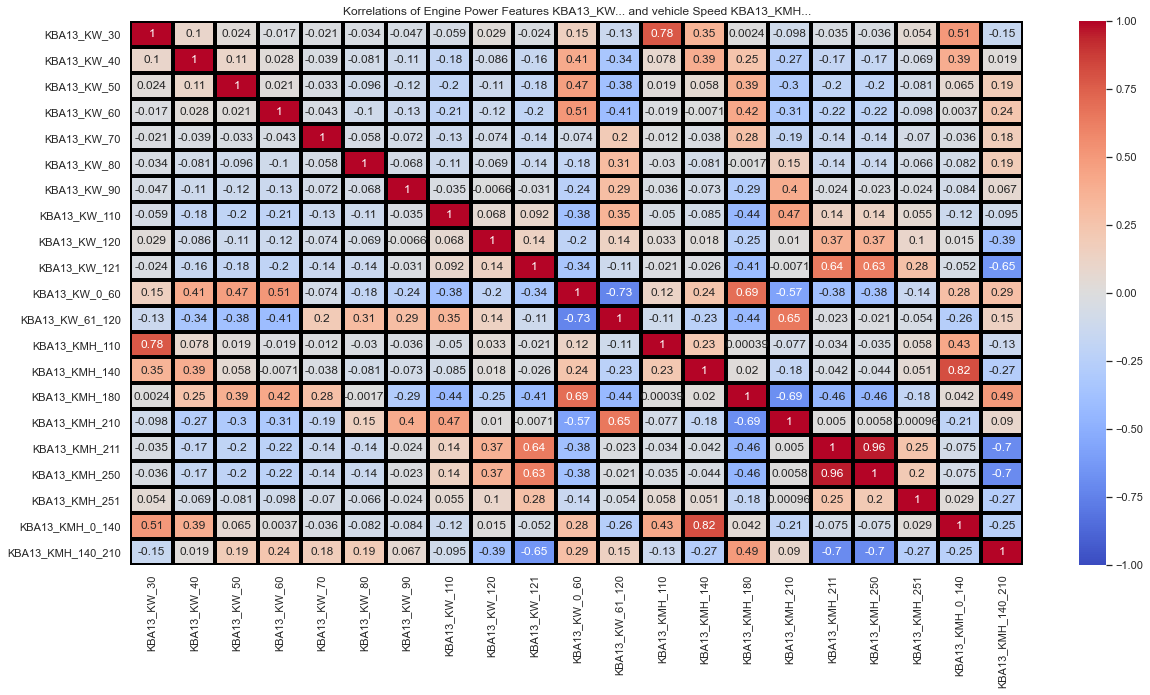

In [107]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
ax.set_title("Korrelations of Engine Power Features KBA13_KW... and vehicle Speed KBA13_KMH...")
sns.heatmap(tdf[[
    'KBA13_KW_30', 'KBA13_KW_40', 
    'KBA13_KW_50', 'KBA13_KW_60', 'KBA13_KW_70', 'KBA13_KW_80', 
    'KBA13_KW_90', 'KBA13_KW_110', 'KBA13_KW_120', 'KBA13_KW_121', 
    'KBA13_KW_0_60', 'KBA13_KW_61_120',
    'KBA13_KMH_110', 'KBA13_KMH_140', 'KBA13_KMH_180', 
    'KBA13_KMH_210', 'KBA13_KMH_211', 'KBA13_KMH_250', 'KBA13_KMH_251', 
    'KBA13_KMH_0_140', 'KBA13_KMH_140_210',
]].astype('float32').corr(),
            annot = True,
            vmin=-1,
            vmax=1,
            center= 0,
            cmap= 'coolwarm',
            linewidths=3,
            linecolor='black',
            ax=ax)

Analogous conclusion like above
* Keep the rough features 'KBA13_KMH_0_140', 'KBA13_KMH_140_210', 'KBA13_KMH_211'
* Delete the others


<AxesSubplot:title={'center':'Korrelations of Engine Power Features KBA13_KW... and vehicle Speed KBA13_KMH...'}>

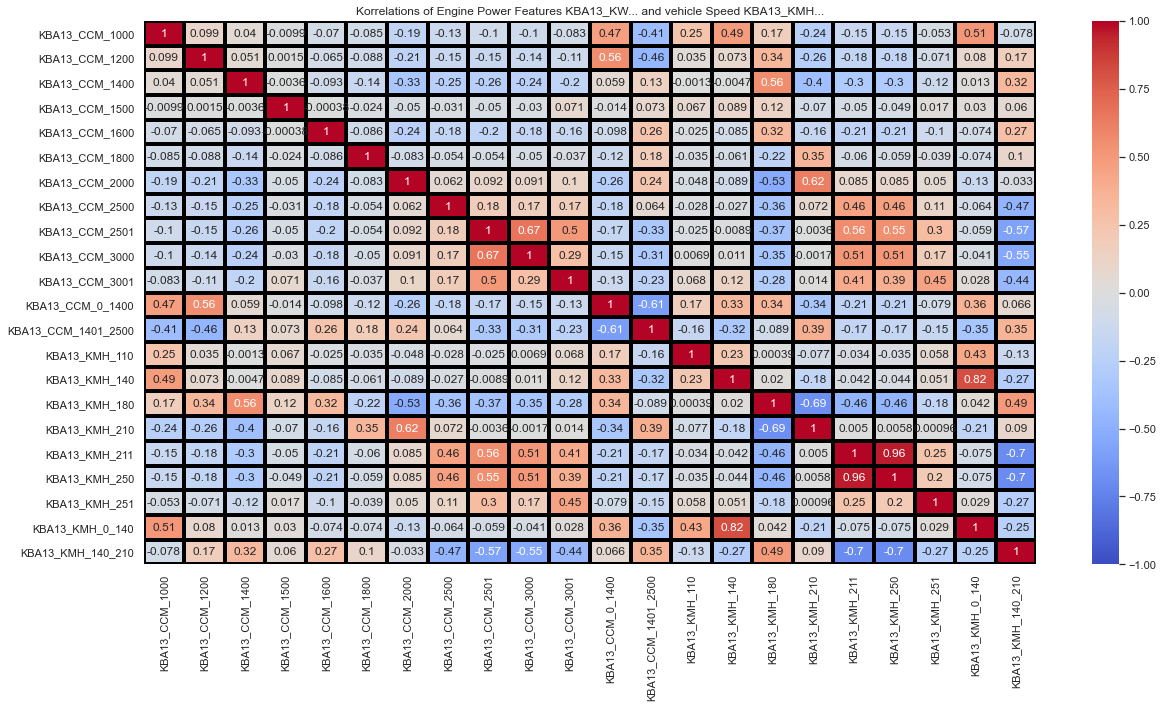

In [108]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
ax.set_title("Korrelations of Engine Power Features KBA13_KW... and vehicle Speed KBA13_KMH...")
sns.heatmap(tdf[[
    'KBA13_CCM_1000', 'KBA13_CCM_1200', 'KBA13_CCM_1400', 'KBA13_CCM_1500', 
    'KBA13_CCM_1600', 'KBA13_CCM_1800', 'KBA13_CCM_2000', 'KBA13_CCM_2500', 
    'KBA13_CCM_2501', 'KBA13_CCM_3000', 'KBA13_CCM_3001', 
    'KBA13_CCM_0_1400', 'KBA13_CCM_1401_2500', 
    'KBA13_KMH_110', 'KBA13_KMH_140', 'KBA13_KMH_180', 
    'KBA13_KMH_210', 'KBA13_KMH_211', 'KBA13_KMH_250', 'KBA13_KMH_251', 
    'KBA13_KMH_0_140', 'KBA13_KMH_140_210',
]].astype('float32').corr(),
            annot = True,
            vmin=-1,
            vmax=1,
            center= 0,
            cmap= 'coolwarm',
            linewidths=3,
            linecolor='black',
            ax=ax)

### Analyze the Aggregation

<AxesSubplot:title={'center':'Korrelations of AGGREGATED Engine Power Features KBA13_KW... and Engine Size features KBA13_CCM... and vehicle Speed KBA13_KMH...'}>

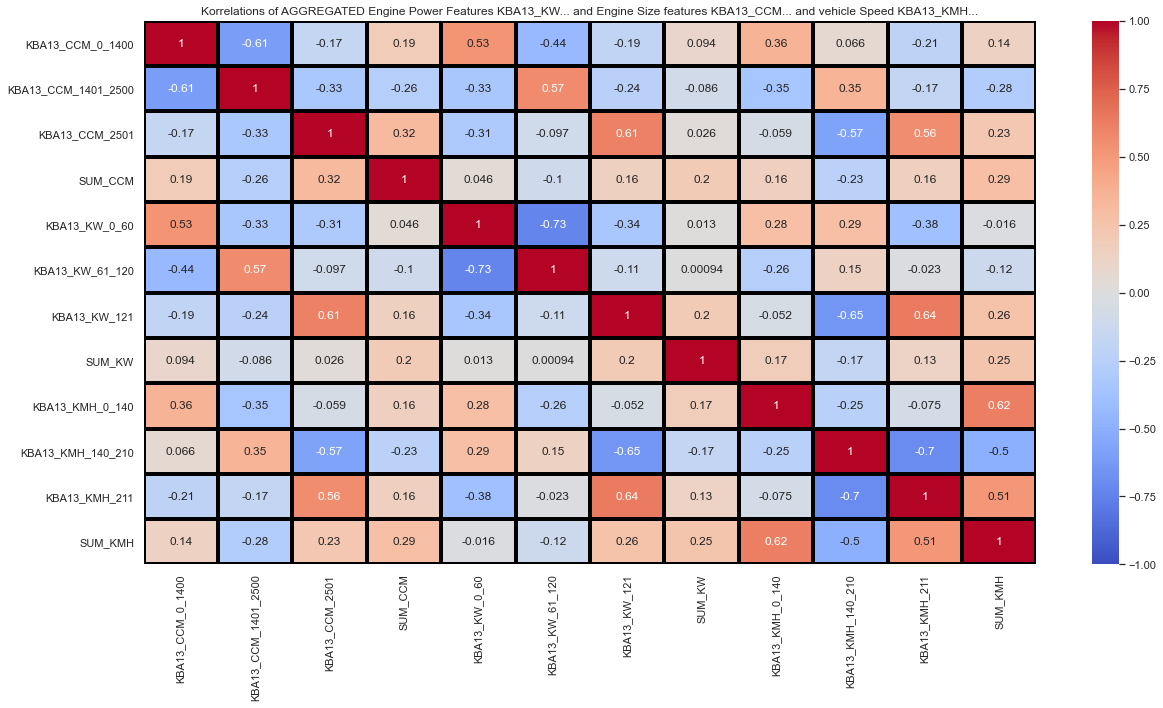

In [109]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
ax.set_title("Korrelations of AGGREGATED Engine Power Features KBA13_KW... and Engine Size features KBA13_CCM... and vehicle Speed KBA13_KMH...")
sns.heatmap(tdf[[
    'KBA13_CCM_0_1400','KBA13_CCM_1401_2500', 'KBA13_CCM_2501','SUM_CCM',
    'KBA13_KW_0_60','KBA13_KW_61_120', 'KBA13_KW_121','SUM_KW',
    'KBA13_KMH_0_140','KBA13_KMH_140_210', 'KBA13_KMH_211','SUM_KMH'
]].astype('float32').corr(),
            annot = True,
            vmin=-1,
            vmax=1,
            center= 0,
            cmap= 'coolwarm',
            linewidths=3,
            linecolor='black',
            ax=ax)

<AxesSubplot:title={'center':'Korrelations of AGGREGATED Engine Power Features KBA13_KW... and Engine Size features KBA13_CCM... and vehicle Speed KBA13_KMH...'}>

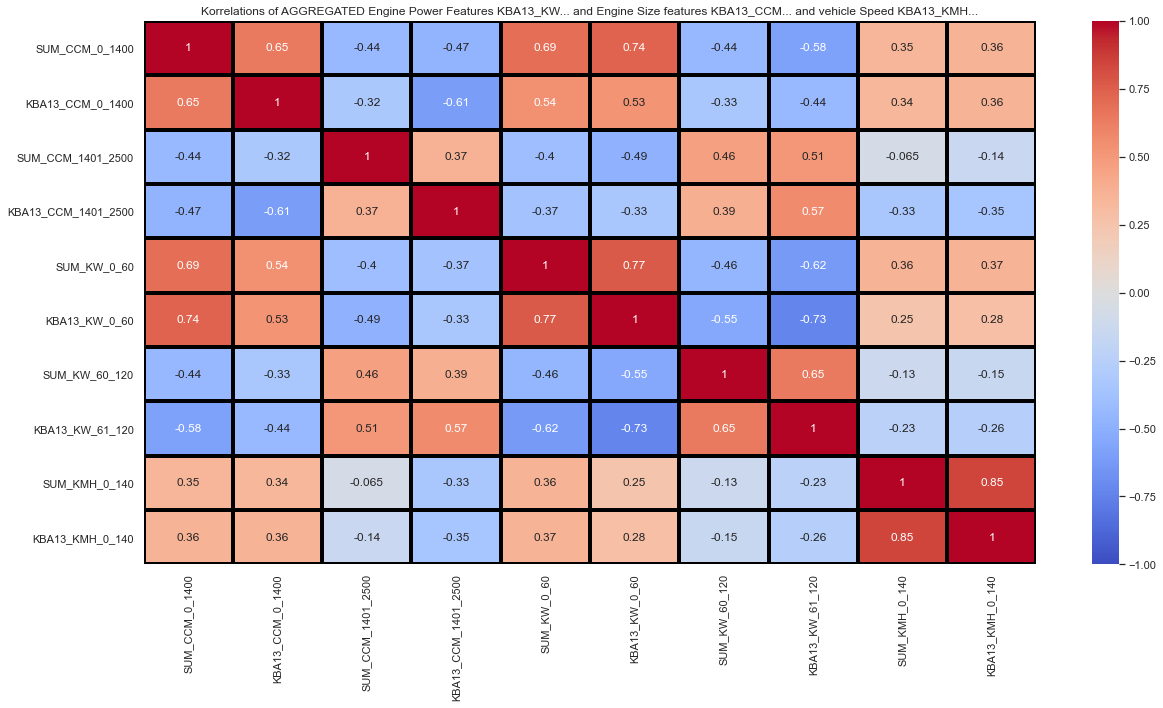

In [110]:
# 'KBA13_KW_30', 'KBA13_KW_40', 
#     'KBA13_KW_50', 'KBA13_KW_60', 'KBA13_KW_70', 'KBA13_KW_80', 
#     'KBA13_KW_90', 'KBA13_KW_110', 'KBA13_KW_120', 'KBA13_KW_121', 
#     'KBA13_KW_0_60', 'KBA13_KW_61_120'

tdf2 = tdf[
    [
        'KBA13_KW_0_60', 'KBA13_KW_61_120', 'KBA13_KW_121',
        'KBA13_CCM_0_1400', 'KBA13_CCM_1401_2500', 'KBA13_CCM_2501',
        'KBA13_KMH_0_140', 'KBA13_KMH_140_210', 'KBA13_KMH_211'
    ]
].copy(deep=True)
tdf2['SUM_KW_0_60'] = tdf['KBA13_KW_30'] + tdf['KBA13_KW_40'] + tdf['KBA13_KW_50'] + tdf['KBA13_KW_60']
tdf2['SUM_KW_60_120'] = tdf['KBA13_KW_70'] + tdf['KBA13_KW_80'] + tdf['KBA13_KW_90'] + tdf['KBA13_KW_110'] + tdf['KBA13_KW_120']
tdf2['SUM_CCM_0_1400'] = tdf['KBA13_CCM_1000'] + tdf['KBA13_CCM_1200'] + tdf['KBA13_CCM_1400']
tdf2['SUM_CCM_1401_2500'] = tdf['KBA13_CCM_1500'] + tdf['KBA13_CCM_1600'] + tdf['KBA13_CCM_1800'] + tdf['KBA13_CCM_2000'] + tdf['KBA13_CCM_2500']
tdf2['SUM_KMH_0_140'] = tdf['KBA13_KMH_110'] + tdf['KBA13_KMH_140'] #+ tdf['KBA13_KMH_211']
tdf2['SUM_KMH_140_210'] = tdf['KBA13_KMH_110'] + tdf['KBA13_KMH_140'] #+ tdf['KBA13_KMH_211']

fig, ax = plt.subplots(1, 1, figsize = (20, 10))
ax.set_title("Korrelations of AGGREGATED Engine Power Features KBA13_KW... and Engine Size features KBA13_CCM... and vehicle Speed KBA13_KMH...")
sns.heatmap(tdf2[[
    'SUM_CCM_0_1400', 'KBA13_CCM_0_1400', 'SUM_CCM_1401_2500', 'KBA13_CCM_1401_2500',
    'SUM_KW_0_60', 'KBA13_KW_0_60', 'SUM_KW_60_120', 'KBA13_KW_61_120', 
    'SUM_KMH_0_140', 'KBA13_KMH_0_140'
]].astype('float32').corr(),
            annot = True,
            vmin=-1,
            vmax=1,
            center= 0,
            cmap= 'coolwarm',
            linewidths=3,
            linecolor='black',
            ax=ax)

In [111]:
del tdf, tdf2

* All in all it makes most sense to use the rough features:
    * 'KBA13_KW_0_60', 'KBA13_KW_61_120', 'KBA13_KW_121'
    * Throw away all other KBA13_KW... features
    * 'KBA13_CCM_0_1400', 'KBA13_CCM_1401_2500', 'KBA13_CCM_2501',
    * Throw away all other KBA13_CCM... features
    * 'KBA13_KMH_0_140', 'KBA13_KMH_140_210', 'KBA13_KMH_211'
    * Throw away all other KBA13_KMH... features

## Check columns with numeric datatypes (non categorical) from Documentation

As we can see in the documentation most columns are already label encoded that means categorical. We interested to find pure numerical columns. 
First we start with the ones documented as numerical.

In [113]:
# create a list of features that you want to compare or examine
# employment types
n_bins = 30 # define n_bins

# function to plot histograms
def plot_hists(df, column_names, title_prefix, total_cols=3, n_bins=30):
    sns.set_theme()
    num_plots=len(column_names)
    additional_row = 1 if num_plots%total_cols > 0 else 0
    total_rows = num_plots//total_cols + additional_row

    fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols,
                            figsize=(7*total_cols, 7*total_rows),
                            constrained_layout=True)

    for i, column_name in enumerate(column_names):
        row = i//total_cols
        pos = i % total_cols
        sns.histplot(df[column_name], bins=n_bins, ax=axs[row][pos])
        axs[row][pos].set_title(f"{title_prefix} {column_name}")

    plt.show()

### Look in CUSTOMERS

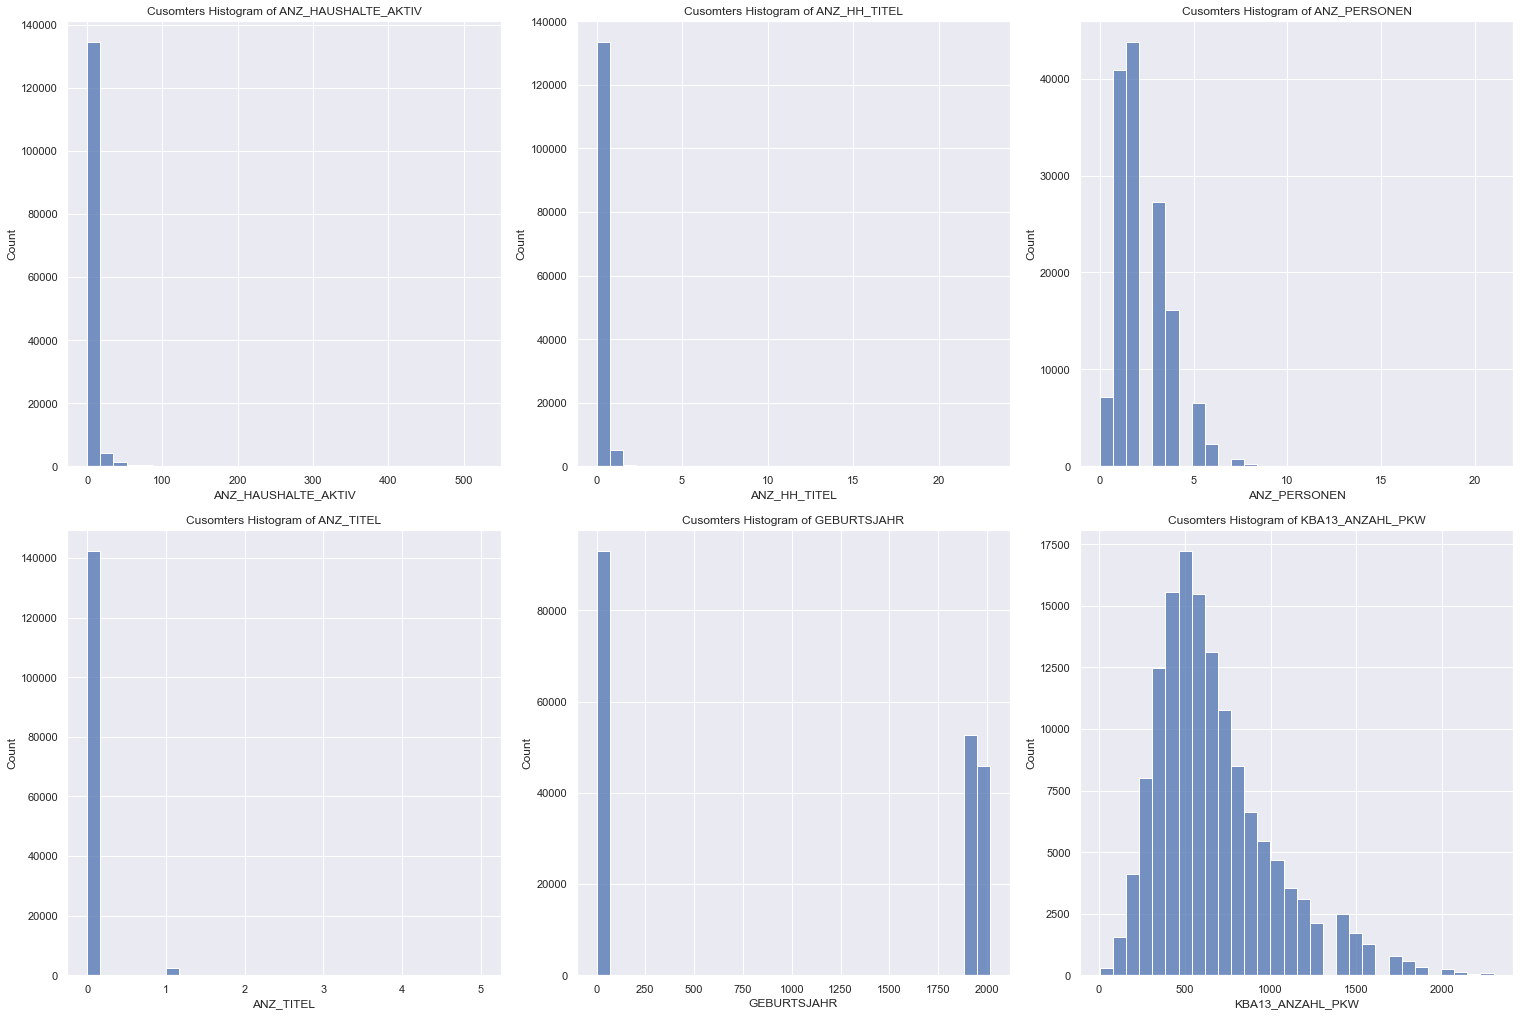

In [114]:
plot_hists(customers, numeric_attributes_from_meta_dict, "Cusomters Histogram of")

In [115]:
customers[numeric_attributes_from_meta_dict].describe()

ANZ_HAUSHALTE_AKTIV   ANZ_HH_TITEL   ANZ_PERSONEN      ANZ_TITEL  \
count        141725.000000  139542.000000  145056.000000  145056.000000   
mean              4.965863       0.067413       2.267828       0.020392   
std              14.309694       0.545576       1.390620       0.152234   
min               0.000000       0.000000       0.000000       0.000000   
25%               1.000000       0.000000       1.000000       0.000000   
50%               1.000000       0.000000       2.000000       0.000000   
75%               4.000000       0.000000       3.000000       0.000000   
max             523.000000      23.000000      21.000000       5.000000   

         GEBURTSJAHR  KBA13_ANZAHL_PKW  
count  191652.000000     140371.000000  
mean     1003.392733        667.231216  
std       974.531081        340.481722  
min         0.000000          5.000000  
25%         0.000000        430.000000  
50%      1926.000000        593.000000  
75%      1949.000000        828.000000  
max      2017.000000       2300.000000

### Look in AZDIAS

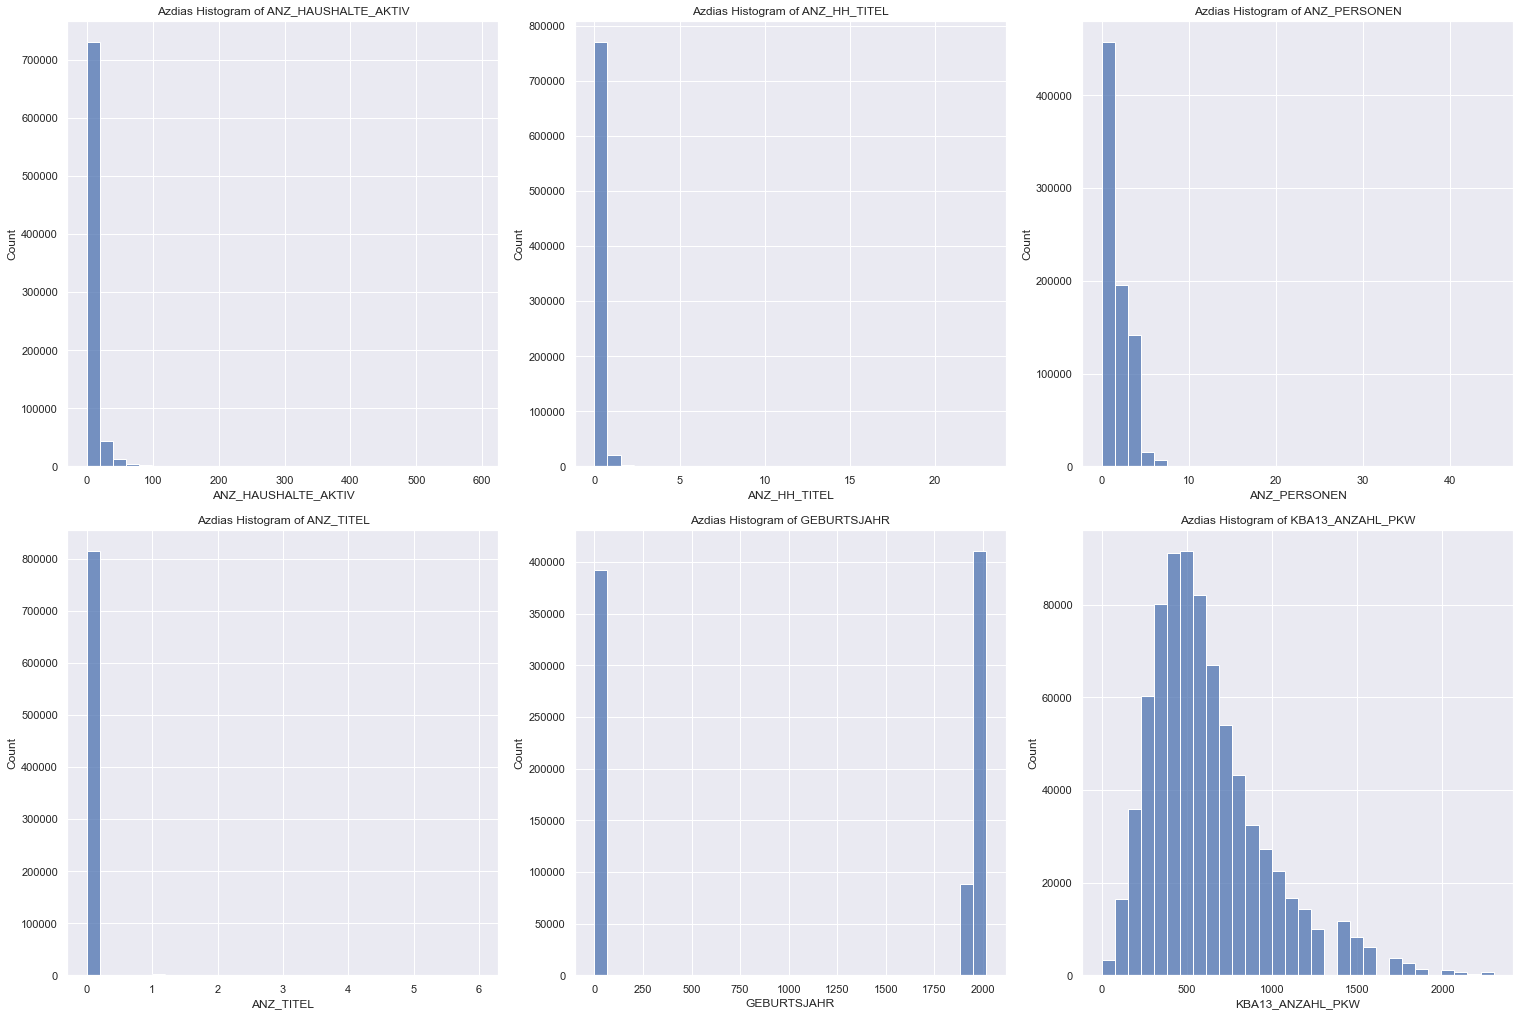

In [116]:
plot_hists(azdias, numeric_attributes_from_meta_dict, "Azdias Histogram of")

In [117]:
azdias[numeric_attributes_from_meta_dict].describe()

ANZ_HAUSHALTE_AKTIV   ANZ_HH_TITEL   ANZ_PERSONEN      ANZ_TITEL  \
count        798073.000000  794213.000000  817722.000000  817722.000000   
mean              8.287263       0.040647       1.727637       0.004162   
std              15.628087       0.324028       1.155849       0.068855   
min               0.000000       0.000000       0.000000       0.000000   
25%               1.000000       0.000000       1.000000       0.000000   
50%               4.000000       0.000000       1.000000       0.000000   
75%               9.000000       0.000000       2.000000       0.000000   
max             595.000000      23.000000      45.000000       6.000000   

         GEBURTSJAHR  KBA13_ANZAHL_PKW  
count  891221.000000     785421.000000  
mean     1101.178533        619.701439  
std       976.583551        340.034318  
min         0.000000          0.000000  
25%         0.000000        384.000000  
50%      1943.000000        549.000000  
75%      1970.000000        778.000000  
max      2017.000000       2300.000000

## Find and check the undocumented numeric attributes
Now we want to find the undocumented attributes. Therefore wen examine the histograms.

### Look in CUSTOMERS

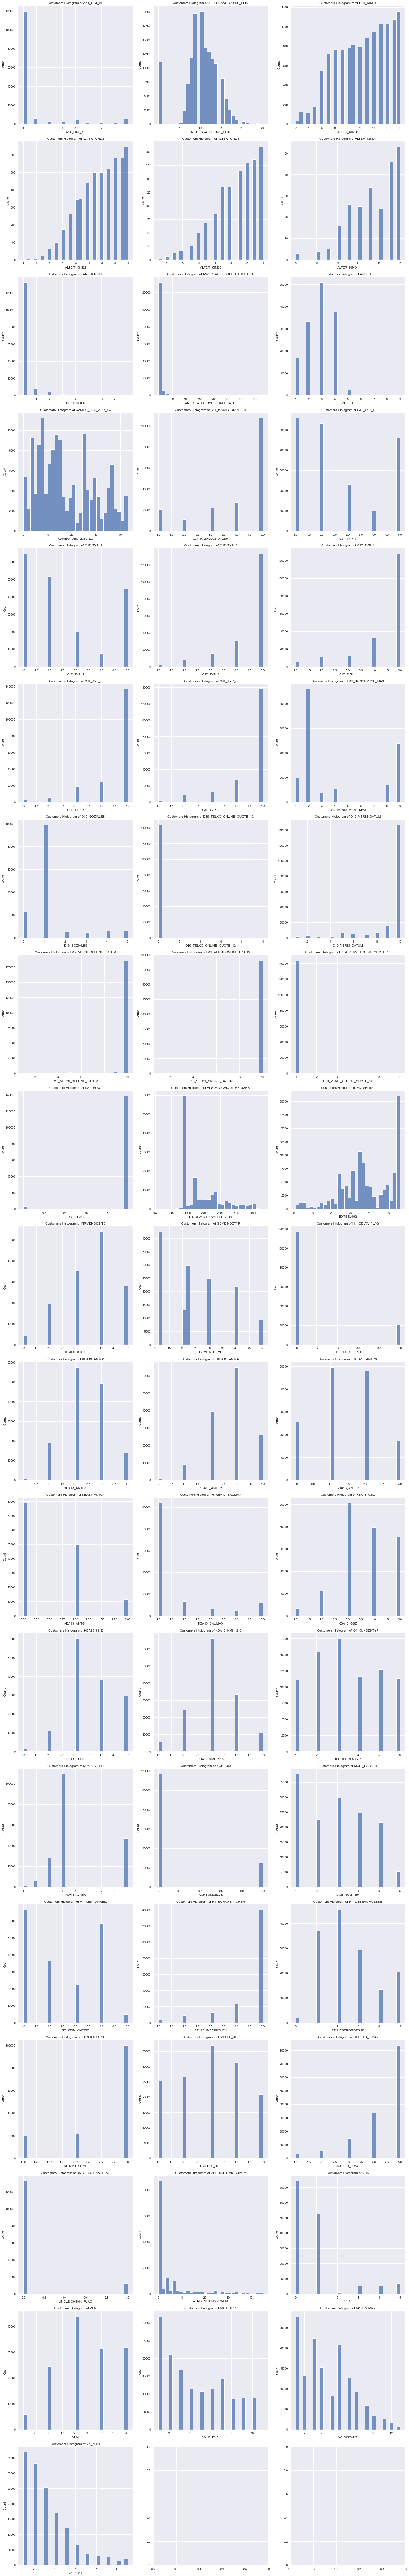

Wall time: 3min 37s


In [118]:
%%time
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
cols = sorted([col for col in (set(customers.columns)- set(meta_dict.keys()))
               if col in customers.columns and customers[col].dtype in numerics])
plot_hists(customers, cols, "Customers Histogram of")

### Look in AZDIAS

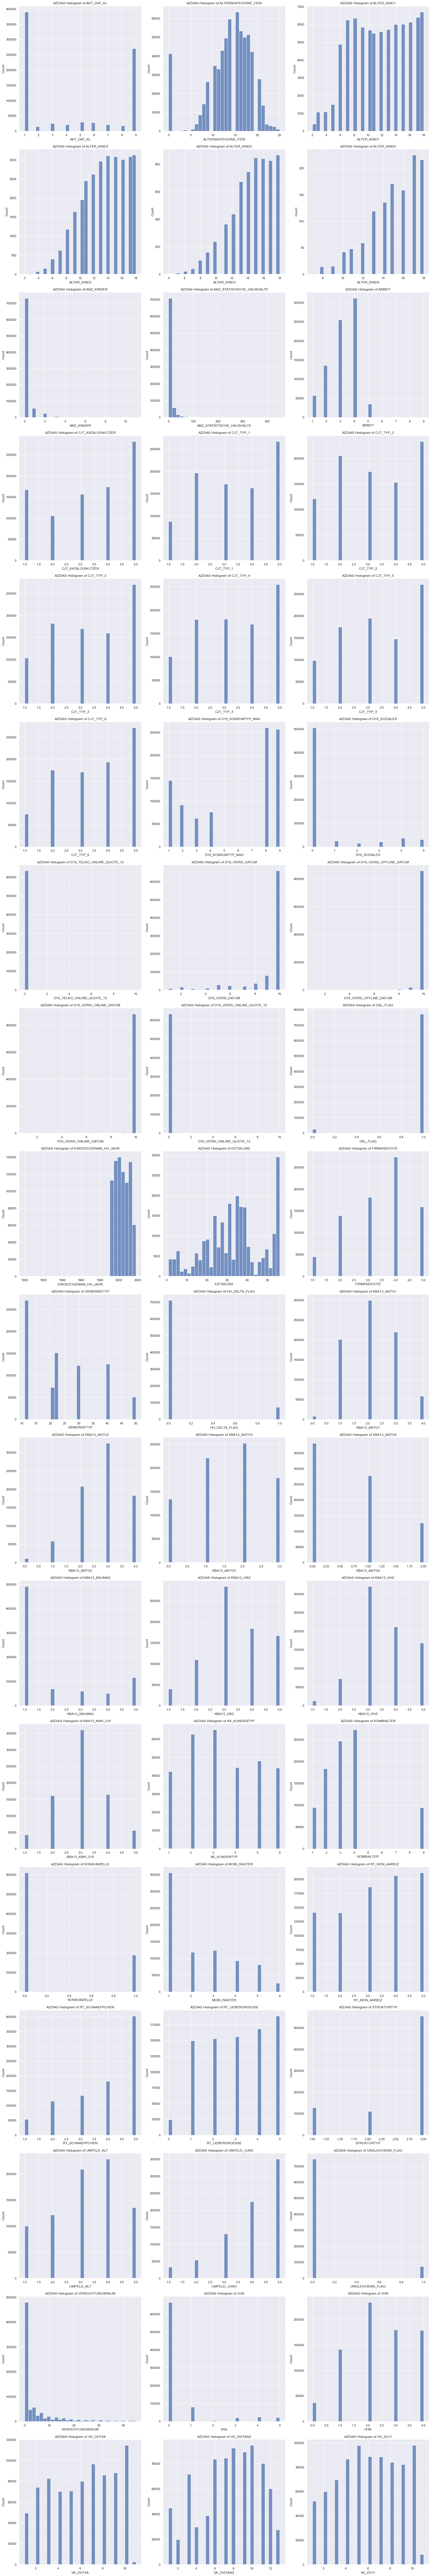

Wall time: 4min 1s


In [119]:
%%time
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
cols = sorted([col for col in (set(azdias.columns)- set(meta_dict.keys()))
               if col in azdias.columns and azdias[col].dtype in numerics])
plot_hists(azdias, cols, "AZDIAS Histogram of")

In [120]:
print(set(cols) - set(customers.columns)- set(meta_dict.keys()))


set()


* looks like the attribute **'ALTERSKATEGORIE_FEIN'** has the unknow category 0.0
* looks like the attribute **'KOMBIALTER'** has the unknown category 9.0

### Findings
Prefix *'ANZ_'* is an Abbreviation for *'Anzahl'* meaning number (of ...)
The undocumented attributes identified as numeric attributes are:
* 'ALTER_KIND1',
* 'ALTER_KIND2',
* 'ALTER_KIND3',
* 'ALTER_KIND4',
* 'ANZ_KINDER',
* 'ANZ_STATISTISCHE_HAUSHALTE',
* 'ARBEIT',
* 'EINGEZOGENAM_HH_JAHR',
* 'EXTSEL992',
* 'VERDICHTUNGSRAUM',

In [121]:
probably_numeric_attributes = [
    'ALTER_KIND1',
    'ALTER_KIND2',
    'ALTER_KIND3',
    'ALTER_KIND4',
    'ANZ_KINDER',
    'ANZ_STATISTISCHE_HAUSHALTE',
    'ARBEIT',
    'EINGEZOGENAM_HH_JAHR',
    'EXTSEL992',
    'VERDICHTUNGSRAUM',
]

numeric_attributes = numeric_attributes_from_meta_dict + probably_numeric_attributes
numeric_attributes=sorted(list(set(numeric_attributes)))

In [122]:
len(numeric_attributes)

16

In [123]:
sorted(numeric_attributes)

['ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_KINDER',
 'ANZ_PERSONEN',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'ANZ_TITEL',
 'ARBEIT',
 'EINGEZOGENAM_HH_JAHR',
 'EXTSEL992',
 'GEBURTSJAHR',
 'KBA13_ANZAHL_PKW',
 'VERDICHTUNGSRAUM']

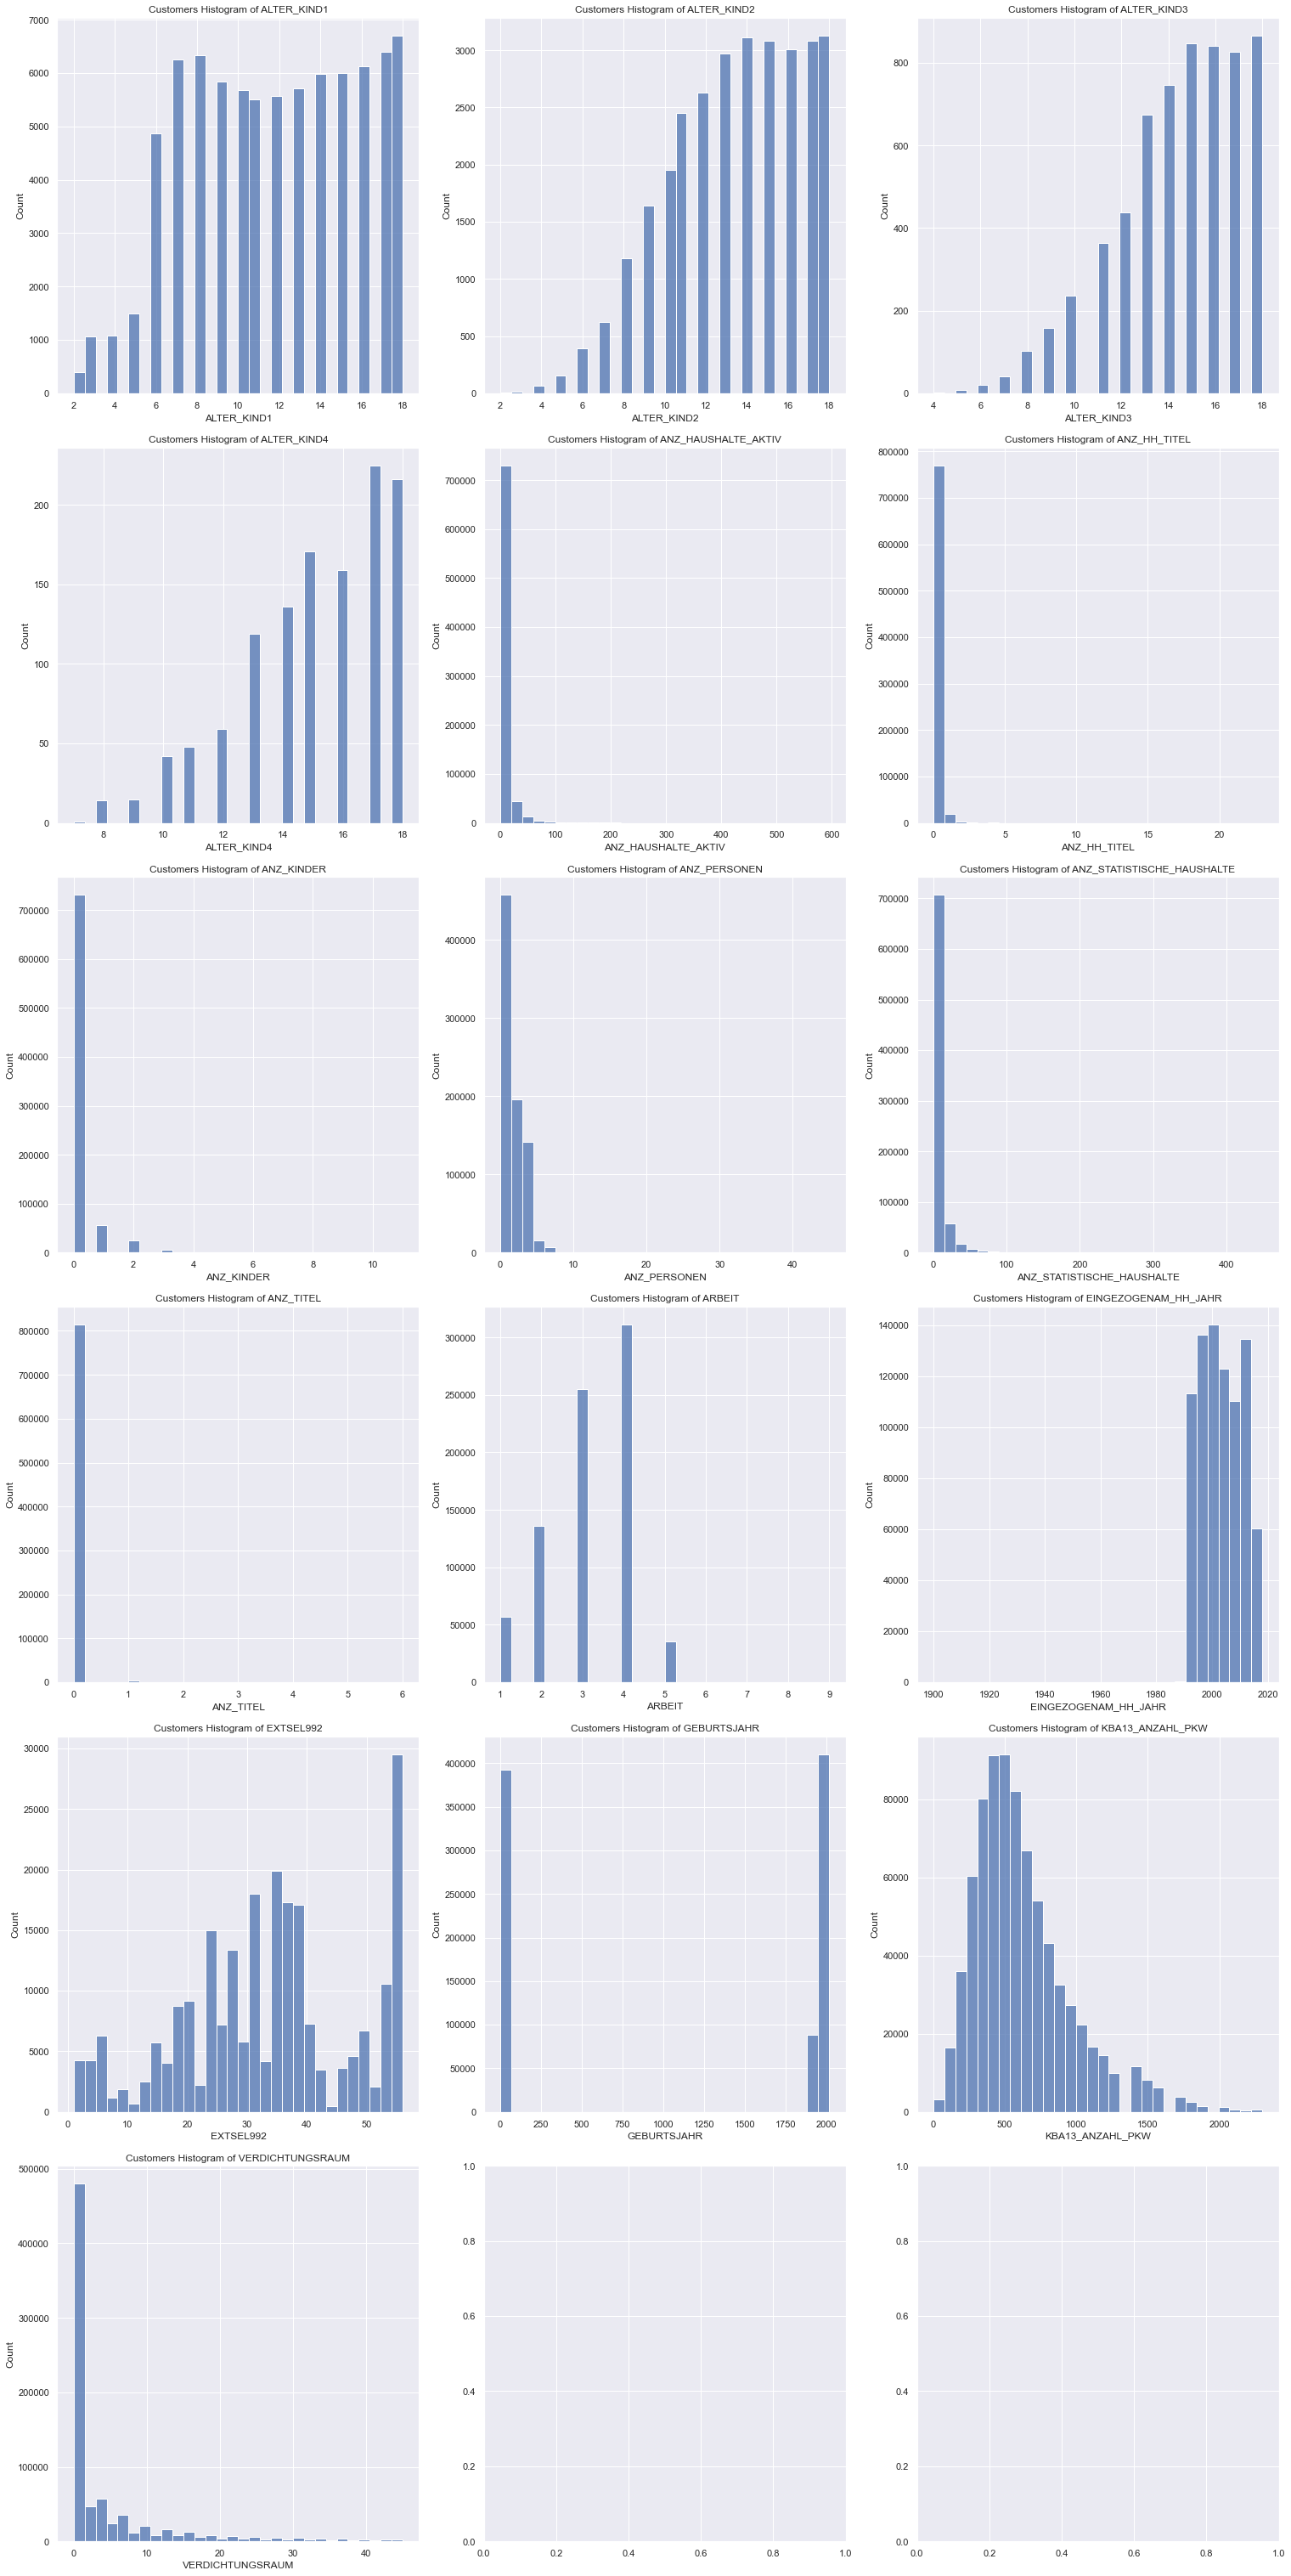

In [124]:
plot_hists(azdias, numeric_attributes, "Customers Histogram of")

 * The attribute **'GEBURTSJAHR'** looks like having an unknown value 0
 * The attribute **'VERDICHTUNGSRAUM'** looks like having an unknown value 0

## Binary Attributes

In [125]:
def binary_attributes(df):
    binary_atts = []
    for col in df.columns:
        vals = df[col].dropna().value_counts()
        if len(vals) == 2:
            binary_atts.append(col)
    return sorted(binary_atts)

In [126]:
print(f"cusomters {binary_attributes(customers)}")

print(f"azdias {binary_attributes(azdias)}")

print(f"mailout_train {binary_attributes(mailout_train)}")

print(f"mailout_test {binary_attributes(mailout_test)}")

cusomters ['ANREDE_KZ', 'DSL_FLAG', 'GREEN_AVANTGARDE', 'HH_DELTA_FLAG', 'KONSUMZELLE', 'OST_WEST_KZ', 'SOHO_KZ', 'UNGLEICHENN_FLAG']
azdias ['ANREDE_KZ', 'DSL_FLAG', 'GREEN_AVANTGARDE', 'HH_DELTA_FLAG', 'KONSUMZELLE', 'OST_WEST_KZ', 'SOHO_KZ', 'UNGLEICHENN_FLAG']
mailout_train ['ANREDE_KZ', 'DSL_FLAG', 'GREEN_AVANTGARDE', 'HH_DELTA_FLAG', 'KONSUMZELLE', 'OST_WEST_KZ', 'RESPONSE', 'SOHO_KZ', 'UNGLEICHENN_FLAG']
mailout_test ['ANREDE_KZ', 'DSL_FLAG', 'GREEN_AVANTGARDE', 'HH_DELTA_FLAG', 'KONSUMZELLE', 'OST_WEST_KZ', 'SOHO_KZ', 'UNGLEICHENN_FLAG']


* ['ANREDE_KZ', 'DSL_FLAG', 'GREEN_AVANTGARDE', 'HH_DELTA_FLAG', 'KONSUMZELLE', 'OST_WEST_KZ', 'SOHO_KZ', 'UNGLEICHENN_FLAG']
are binary attruibutes in all of the dataframes
* *mailout_train* contains *'RESPONSE'* in addition but as the others don't contain this attribute it ca not be regarded
as binary
*  *'OST_WEST_KZ'* needs further encoding as it is not numerical

# Outliers
To detect and fix outliers we apply Tukeys fence method based on the inter quartile range...

## Tukey

In [128]:
#https://datatest.readthedocs.io/en/stable/how-to/outliers.html
def lambda_replace_outliers_by_thresholds(val, lower_lim, upper_lim):
    if pd.isnull(val):
        return val
    if val < lower_lim:
        return lower_lim
    if val > upper_lim:
        return upper_lim
    return val

def upper_outliers_df(original_df, cols, multiplier=2.2):
    df =pd.DataFrame()
    for col in cols:
        column_content = upper_outliers_column_values(original_df, col, multiplier)
        if column_content.loc['is_outlier']:
            df[col] = column_content
    if len(df.columns) > 0:
        df.index = column_content.index
    return df

def lower_outliers_df(original_df, cols, multiplier=2.2):
    df =pd.DataFrame()
    for col in cols:
        column_content = lower_outliers_column_values(original_df, col, multiplier)
        if column_content.loc['is_outlier']:
            df[col] = column_content
    if len(df.columns) > 0:
        df.index = column_content.index
    return df


def upper_outliers_column_values(df, column_name, multiplier=2.2):
    q1 =  df[column_name].quantile(0.25)
    q3 =  df[column_name].quantile(0.75)
    iqr = q3 - q1
    upper_lim = q3 + (iqr * multiplier)
    num_all = df[column_name].apply(lambda it: it if pd.isnull(it) else 1).sum()
    num_upper_out = df[column_name][df[column_name] > upper_lim].apply(lambda it: it if pd.isnull(it) else 1).sum()

    df_non_null = df[column_name].dropna()
    val_cnts = df_non_null.value_counts()#.sort_index()
    return pd.Series({
        'is_outlier': num_upper_out > 0,
        'limit': upper_lim,
        'outlier_abs_count': num_upper_out,
        'outlier_pct_count': 100*num_upper_out/num_all,
        'column_value_cnt': df_non_null.count(),
        'column_distinct_count': len(val_cnts),
        'mean': round(df[column_name].mean(),4),
        'std': round(df[column_name].std(),4),
        'min': round(df[column_name].min(),4),
        'q1': round(q1,4),
        'median': round(df[column_name].quantile(0.5),4),
        'q3': round(q3,4),
        'max': round(df[column_name].max(),4),
    })

def lower_outliers_column_values(df, column_name, multiplier=2.2):
    q1 =  df[column_name].quantile(0.25)
    q3 =  df[column_name].quantile(0.75)
    iqr = q3 - q1
    lower_lim = q1 - (iqr * multiplier)
    num_all = df[column_name].apply(lambda it: it if pd.isnull(it) else 1).sum()
    num_lower_out = df[column_name][df[column_name] < lower_lim].apply(lambda it: it if pd.isnull(it) else 1).sum()

    df_non_null = df[column_name].dropna()
    val_cnts = df_non_null.value_counts()
    return pd.Series({
        'is_outlier': num_lower_out > 0,
        'limit': lower_lim,
        'outlier_abs_count': num_lower_out,
        'outlier_pct_count': 100*num_lower_out/num_all,
        'column_value_cnt': df_non_null.count(),
        'column_distinct_count': len(val_cnts),
        'mean': round(df[column_name].mean(),4),
        'std': round(df[column_name].std(),4),
        'min': round(df[column_name].min(),4),
        'q1': round(q1,4),
        'median': round(df[column_name].quantile(0.5),4),
        'q3': round(q3,4),
        'max': round(df[column_name].max(),4),
    })


In [129]:
upper_outliers_df(azdias, numeric_attributes, 2.2)

ANZ_HAUSHALTE_AKTIV ANZ_HH_TITEL ANZ_KINDER  \
is_outlier                           True         True       True   
limit                                26.6            0          0   
outlier_abs_count                   43941        23969      86480   
outlier_pct_count                 5.50589      3.01796    10.5757   
column_value_cnt                   798073       794213     817722   
column_distinct_count                 292           21         11   
mean                               8.2873       0.0406      0.154   
std                               15.6281        0.324     0.5024   
min                                     0            0          0   
q1                                      1            0          0   
median                                  4            0          0   
q3                                      9            0          0   
max                                   595           23         11   

                      ANZ_PERSONEN ANZ_STATISTISCHE_HAUSHALTE ANZ_TITEL  \
is_outlier                    True                       True      True   
limit                          4.2                       26.6         0   
outlier_abs_count            22735                      38955      3180   
outlier_pct_count          2.78028                    4.88113  0.388885   
column_value_cnt            817722                     798073    817722   
column_distinct_count           30                        268         6   
mean                        1.7276                     7.5994    0.0042   
std                         1.1558                    14.3322    0.0689   
min                              0                          0         0   
q1                               1                          1         0   
median                           1                          3         0   
q3                               2                          9         0   
max                             45                        449         6   

                          ARBEIT KBA13_ANZAHL_PKW VERDICHTUNGSRAUM  
is_outlier                  True             True             True  
limit                        6.2           1644.8               16  
outlier_abs_count            159            10629            71496  
outlier_pct_count      0.0200251          1.35329          9.00514  
column_value_cnt          794005           785421           793947  
column_distinct_count          6             1261               46  
mean                      3.1679          619.701           4.5858  
std                       1.0024          340.034           8.4715  
min                            1                0                0  
q1                             3              384                0  
median                         3              549                1  
q3                             4              778                5  
max                            9             2300               45

In [130]:
lower_outliers_df(azdias, numeric_attributes, 2.2)

ALTER_KIND3 ALTER_KIND4 EINGEZOGENAM_HH_JAHR
is_outlier                   True        True                 True
limit                         4.2         7.4               1968.4
outlier_abs_count               2           1                    2
outlier_pct_count       0.0324149   0.0829876          0.000244582
column_value_cnt             6170        1205               817722
column_distinct_count          15          12                   37
mean                       14.476     15.0896              2003.73
std                        2.7124      2.4529               7.0582
min                             4           7                 1900
q1                             13          14                 1997
median                         15          15                 2003
q3                             17          17                 2010
max                            18          18                 2018


* We will use 2.2 as multiplier 
* We will apply outlier handling as soon as 3% or more outliers occur in a feature


## Features with low variance (or equivalent low stddev)
Removing features with low standard is not necenecessary because PCA cares about those features. The reason for this action is that we get exceptions when applying an *IterativeImputer* with the *min_value* and *max_value* parameters bcause removal of the outliers makes some features constant.

In [131]:
def low_stdev_columns(df, threshold=.3):
    result = pd.DataFrame()
    for col in df.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns:
        if df[col].std() < threshold:
            result[col] = df[col]
    if len(result.columns) > 0:
        result.index = df.index
    return result

In [132]:
low_stdev_columns(azdias, .25).describe()

ANZ_TITEL  D19_TELKO_ONLINE_DATUM       DSL_FLAG        SOHO_KZ  \
count  817722.000000           891221.000000  798073.000000  817722.000000   
mean        0.004162                9.981780       0.967816       0.008423   
std         0.068855                0.241035       0.176488       0.091392   
min         0.000000                1.000000       0.000000       0.000000   
25%         0.000000               10.000000       1.000000       0.000000   
50%         0.000000               10.000000       1.000000       0.000000   
75%         0.000000               10.000000       1.000000       0.000000   
max         6.000000               10.000000       1.000000       1.000000   

            TITEL_KZ  
count  817722.000000  
mean        0.003483  
std         0.084957  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         5.000000

#### Experiment try it out - remove outliers
We build some code to remove outliers and execute it to see the influence on the Standard deviation of features

In [135]:
# experiment remove outliers
tmp_azd = azdias.copy(deep=True)
for column_name in numeric_attributes:
    upper_outlier = upper_outliers_column_values(tmp_azd, column_name, multiplier=2.2)
    lower_outlier = lower_outliers_column_values(tmp_azd, column_name, multiplier=2.2)
    upper_limit = upper_outlier.loc['limit'] if upper_outlier.loc['is_outlier'] else 1000000.0
    lower_limit = lower_outlier.loc['limit'] if lower_outlier.loc['is_outlier'] else -1000000.0
    tmp_azd[col] = tmp_azd[col].apply(
                lambda it: lambda_replace_outliers_by_thresholds(it, lower_limit, upper_limit))
low_stdev_columns(tmp_azd, .25).describe()

ALTER_KIND1      ANZ_TITEL  D19_TELKO_ONLINE_DATUM       DSL_FLAG  \
count      81058.0  817722.000000           891221.000000  798073.000000   
mean          16.0       0.004162                9.981780       0.967816   
std            0.0       0.068855                0.241035       0.176488   
min           16.0       0.000000                1.000000       0.000000   
25%           16.0       0.000000               10.000000       1.000000   
50%           16.0       0.000000               10.000000       1.000000   
75%           16.0       0.000000               10.000000       1.000000   
max           16.0       6.000000               10.000000       1.000000   

             SOHO_KZ       TITEL_KZ  
count  817722.000000  817722.000000  
mean        0.008423       0.003483  
std         0.091392       0.084957  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75%         0.000000       0.000000  
max         1.000000       5.000000

In [136]:
del tmp_azd

&rArr; after removing outliers the feature **ALTER_KIND** has constant values and this can be a problem when

## Missing values

* Looking to the EXCEL shows that columns with the description 'no transactions known' and 'unknown' can be regarded as missing values.
* We will use our Preprocessor class to prepare the data

In [137]:
root_path='.'

In [138]:
documentation_df = pd.read_excel(f'{root_path}/../data/DIAS Attributes - Values 2017.xlsx', header=None)\
                .dropna(axis=0, how='all')\
                .dropna(axis=1, how='all')\
                .iloc[1:,:]

documentation = Documentation(documentation_df)
del documentation_df

In [140]:
%%time
out_dir = '01_explore_out'
pre_processor = PreProcessor(root_path=root_path, out_dir=out_dir)
try: 
    # try to load mailout_train from step 2
    pre_processor.load_step_2_outliers_handled_dfs()[2]
except FileNotFoundError:
    azdias = pd.read_csv(f'{root_path}/../data/Udacity_AZDIAS_052018.csv', sep=';')
    customers = pd.read_csv(f'{root_path}/../data/Udacity_CUSTOMERS_052018.csv', sep=';')
    mailout_train = pd.read_csv(f'{root_path}/../data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
    mailout_test = pd.read_csv(f'{root_path}/../data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
    pre_processor = PreProcessor(
        FeatureEngineer(documentation),
        azdias, customers, 
        mailout_train, mailout_test,
        root_path=root_path, out_dir=out_dir
    )
    pre_processor.step1_clean()
    pre_processor.step2_handle_outliers_and_low_std_dev()
pp_azdias, pp_customers, pp_mailout_train, pp_mailout_test = pre_processor.load_step_2_outliers_handled_dfs()
    

<string>:2: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.


Step 1: Clean
azdias, customers
mailout_train, mailout_test


C:\Users\thorssc\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:2446: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE',
       'OST_WEST_KZ'],
      dtype='object')]

  encoding=encoding,


Step 2: Handle Outliers and cols with low stddev
azdias, customers
mailout_train, mailout_test
azdias, customers
mailout_train, mailout_test


C:\Users\thorssc\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:2446: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE',
       'OST_WEST_KZ'],
      dtype='object')]

  encoding=encoding,


Wall time: 8min 22s


In [141]:
def missing_values_df(df_a, df_c):
    """
    Prepare a DataFrame for plotting its missing values...
    """
    labels = [] 
    values_a = [] 
    values_c = [] 

    nrows_a=df_a.shape[0]
    nrows_c=df_c.shape[0]
    for col in df_a.columns:
        number_of_missing_a = df_a[col].isnull().sum()
        number_of_missing_c = df_c[col].isnull().sum()
        if (number_of_missing_a > 0 or number_of_missing_c > 0):
            labels.append(col)
        if (number_of_missing_a > 0):
            values_a.append(number_of_missing_a/nrows_a)
        if (number_of_missing_c > 0):
            values_c.append(number_of_missing_c/nrows_c)
    return pd.DataFrame({"Attribute": labels, "AZDIAS": values_a, "CUSTOMERS": values_c})


def plot_missing_values(df):
    """
    Plot the 
    """
    sns.set_theme()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,65))

    sns.barplot(y="Attribute", x="CUSTOMERS", color='#DD8452', data=df.sort_values(by=['Attribute']), ax=ax1)
    ax1.set_xticks([.0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
    ax1.set_yticks(np.arange(len(df['Attribute'])))
    ax1.set_yticklabels(df['Attribute'], rotation='horizontal')
    ax1.set_xlabel("Percentage of missing values CUSTOMERS")
    ax1.set_title("Variables with missing values CUSTOMERS")

    sns.barplot(y="Attribute", x="AZDIAS", color='#4C72B0', data=df, ax=ax2)
    ax2.set_xticks([.0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
    ax2.set_yticks(np.arange(len(df['Attribute'])))
    ax2.set_yticklabels(df['Attribute'], rotation='horizontal')
    ax2.set_xlabel("Count of missing values AZDIAS")
    ax2.set_title("Variables with missing values AZDIAS")

    fig.tight_layout()
    plt.show()

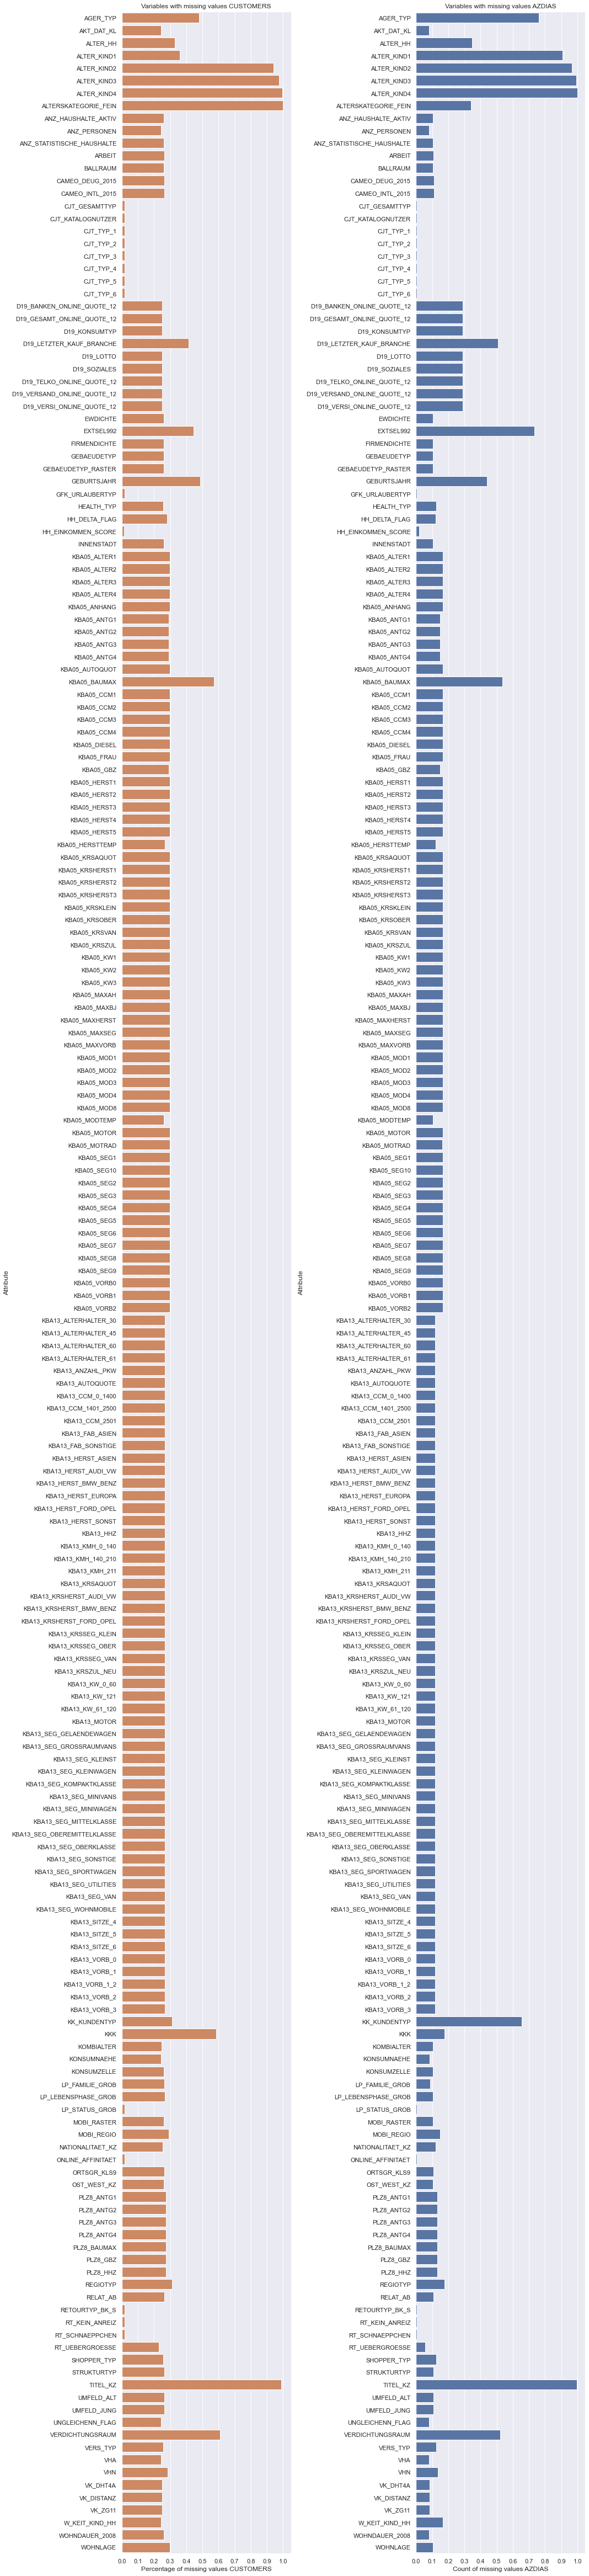

In [142]:
missing_val_df = missing_values_df(pp_azdias, pp_customers)
plot_missing_values(missing_val_df)

In [143]:
print('Correlation between AZDIAS and CUSTOMERS:', missing_val_df['AZDIAS'].corr(missing_val_df['CUSTOMERS']))

Correlation between AZDIAS and CUSTOMERS: 0.9054070298959725


Correlation of approx. **0.9** justifies to sort the dataframe by one attribute to make visualization easier

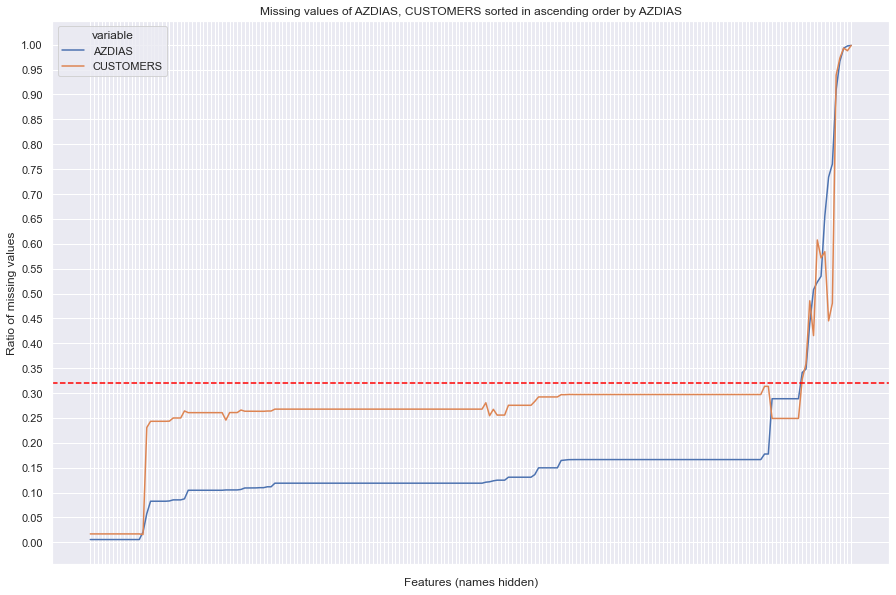

In [146]:
sns.set_theme()
fig, ax = plt.subplots(1, 1, figsize = (15, 10))
graph = sns.lineplot(data=pd.melt(missing_val_df.sort_values(by=['AZDIAS']),['Attribute']), x="Attribute", y='value', hue='variable', ax=ax)

threshold = 0.32
graph.axhline(threshold, ls='--', color='red')
#ax.set_xticklabels(list(missing_val_df.sort_values(by=['AZDIAS'])['Attribute']), rotation=90)
ax.set_xticklabels([])
ax.set_yticks([.0,.05,.1,.15,.2,.25,.3,.35,.4,.45,.5,.55,.6,.65,.7,.75,.8,.85,.9,.95,1])
ax.set_title("Missing values of AZDIAS, CUSTOMERS sorted in ascending order by AZDIAS")
ax.set_xlabel("Features (names hidden)")
ax.set_ylabel("Ratio of missing values")
plt.show()

In [147]:
print("Percentage of missing CUSTOMERS:", pp_customers.isnull().sum().sum() / (pp_customers.shape[0] * pp_customers.shape[1]))
print("Percentage of missing AZDIAS:", pp_azdias.isnull().sum().sum() / (pp_azdias.shape[0] * pp_azdias.shape[1]))
print("Number of features with missing values:", missing_val_df.shape[0])
print(f"Number of AZDIAS-features above threshold ({threshold}):", missing_val_df[missing_val_df['AZDIAS']>threshold].shape[0])

Percentage of missing CUSTOMERS: 0.20033741590782478
Percentage of missing AZDIAS: 0.11931627265534343
Number of features with missing values: 203
Number of AZDIAS-features above threshold (0.32): 14


In [148]:
pp_customers.isnull().sum().sum() / (pp_customers.shape[0] * pp_customers.shape[1])

0.20033741590782478

In [149]:
pp_azdias.isnull().sum().sum() / (pp_azdias.shape[0] * pp_azdias.shape[1])

0.11931627265534343

In [150]:
missing_val_df.shape[0] 

203

In [151]:
missing_val_df[missing_val_df['AZDIAS']>threshold].shape[0]

14

In [152]:
missing_val_df[missing_val_df['AZDIAS']>threshold].shape[0] / missing_val_df.shape[0] 

0.06896551724137931

In [153]:
missing_val_df[missing_val_df['CUSTOMERS']>threshold].shape[0] / missing_val_df.shape[0] 

0.06896551724137931

In [154]:
print('Azdias candidates for removal:\n', list(missing_val_df[missing_val_df['AZDIAS']>threshold]['Attribute']))
print('Customers candidates for removal:\n', list(missing_val_df[missing_val_df['CUSTOMERS']>threshold]['Attribute']))

Azdias candidates for removal:
 ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'D19_LETZTER_KAUF_BRANCHE', 'EXTSEL992', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ', 'VERDICHTUNGSRAUM']
Customers candidates for removal:
 ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'D19_LETZTER_KAUF_BRANCHE', 'EXTSEL992', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ', 'VERDICHTUNGSRAUM']


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')